# Statistical Theory Final Project
### ***What Socioeconomic Factors Impact Life Expectancy?***
Nitzan Ron, ID 215451709

Adam Zelzer, ID 328489166




In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from utilities import *

In [182]:
mpl.rcParams['figure.dpi'] = 400
plt.rcParams["font.family"]="serif"

## Data
Taken from Kaggle, but is based on data from the following sources:

Average life expectancy of both genders in different years from 2000 to 2015:

https://www.who.int/data/gho/data/indicators/indicator-details/GHO/life-expectancy-at-birth-(years)

Alcohol consumption that is recorded in liters of pure alcohol per capita with 15+ years old:

https://www.who.int/data/gho/data/indicators/indicator-details/GHO/alcohol-recorded-per-capita-(15-)-consumption-(in-litres-of-pure-alcohol)

BMI:

https://www.ncdrisc.org/data-downloads-adiposity.html

GDP per capita in current USD:

https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?most_recent_year_desc=true

Total population in millions:

https://data.worldbank.org/indicator/SP.POP.TOTL?most_recent_year_desc=true

Average years that people aged 25+ spent in formal education:

https://ourworldindata.org/grapher/mean-years-of-schooling-long-run


In [183]:
columns = ["Country",
           "Region",
           "Year",
           "Population_mln",
           "GDP_per_capita",
           "BMI",
           "Alcohol_consumption",
           "Schooling",
           "Life_expectancy"]

renamed_columns = {"Population_mln": "Population (millions)",
                   "GDP_per_capita": "GDP per capita ($)",
                   "BMI": "BMI (kg/m^2)",
                   "Alcohol_consumption": "Alcohol consumption (L)",
                   "Schooling": "Schooling (years)",
                   "Life_expectancy": "Life expectancy (years)"
                  }

data = pd.read_csv("Life-Expectancy-Data.csv")[columns].rename(columns=renamed_columns)
data.head()

Country          Region  Year  Population (millions)  GDP per capita ($)  \
0  Turkiye     Middle East  2015                  78.53               11006   
1    Spain  European Union  2015                  46.44               25742   
2    India            Asia  2007                1183.21                1076   
3   Guyana   South America  2006                   0.75                4146   
4   Israel     Middle East  2012                   7.91               33995   

   BMI (kg/m^2)  Alcohol consumption (L)  Schooling (years)  \
0          27.8                     1.32                7.8   
1          26.0                    10.35                9.7   
2          21.2                     1.57                5.0   
3          25.3                     5.68                7.9   
4          27.0                     2.89               12.8   

   Life expectancy (years)  
0                     76.5  
1                     82.8  
2                     65.4  
3                     67.0  
4                     81.7

In [184]:
def add_continents(df):
    df.loc[df["Region"]=="European Union", "Region"] = "Europe"
    df.loc[df["Region"]=="Rest of Europe", "Region"] = "Europe"
    df.loc[df["Region"]=="Middle East", "Region"] = "Asia"
    df.loc[df["Region"]=="Central America and Caribbean", "Region"] = "South America"

    df.rename(columns={"Region": "Continent"}, inplace=True)

add_continents(data)

In [185]:
data.insert(5, "log GDP per capita", np.log10(data["GDP per capita ($)"]))
data.insert(4, "log Population", np.log10(data["Population (millions)"]))

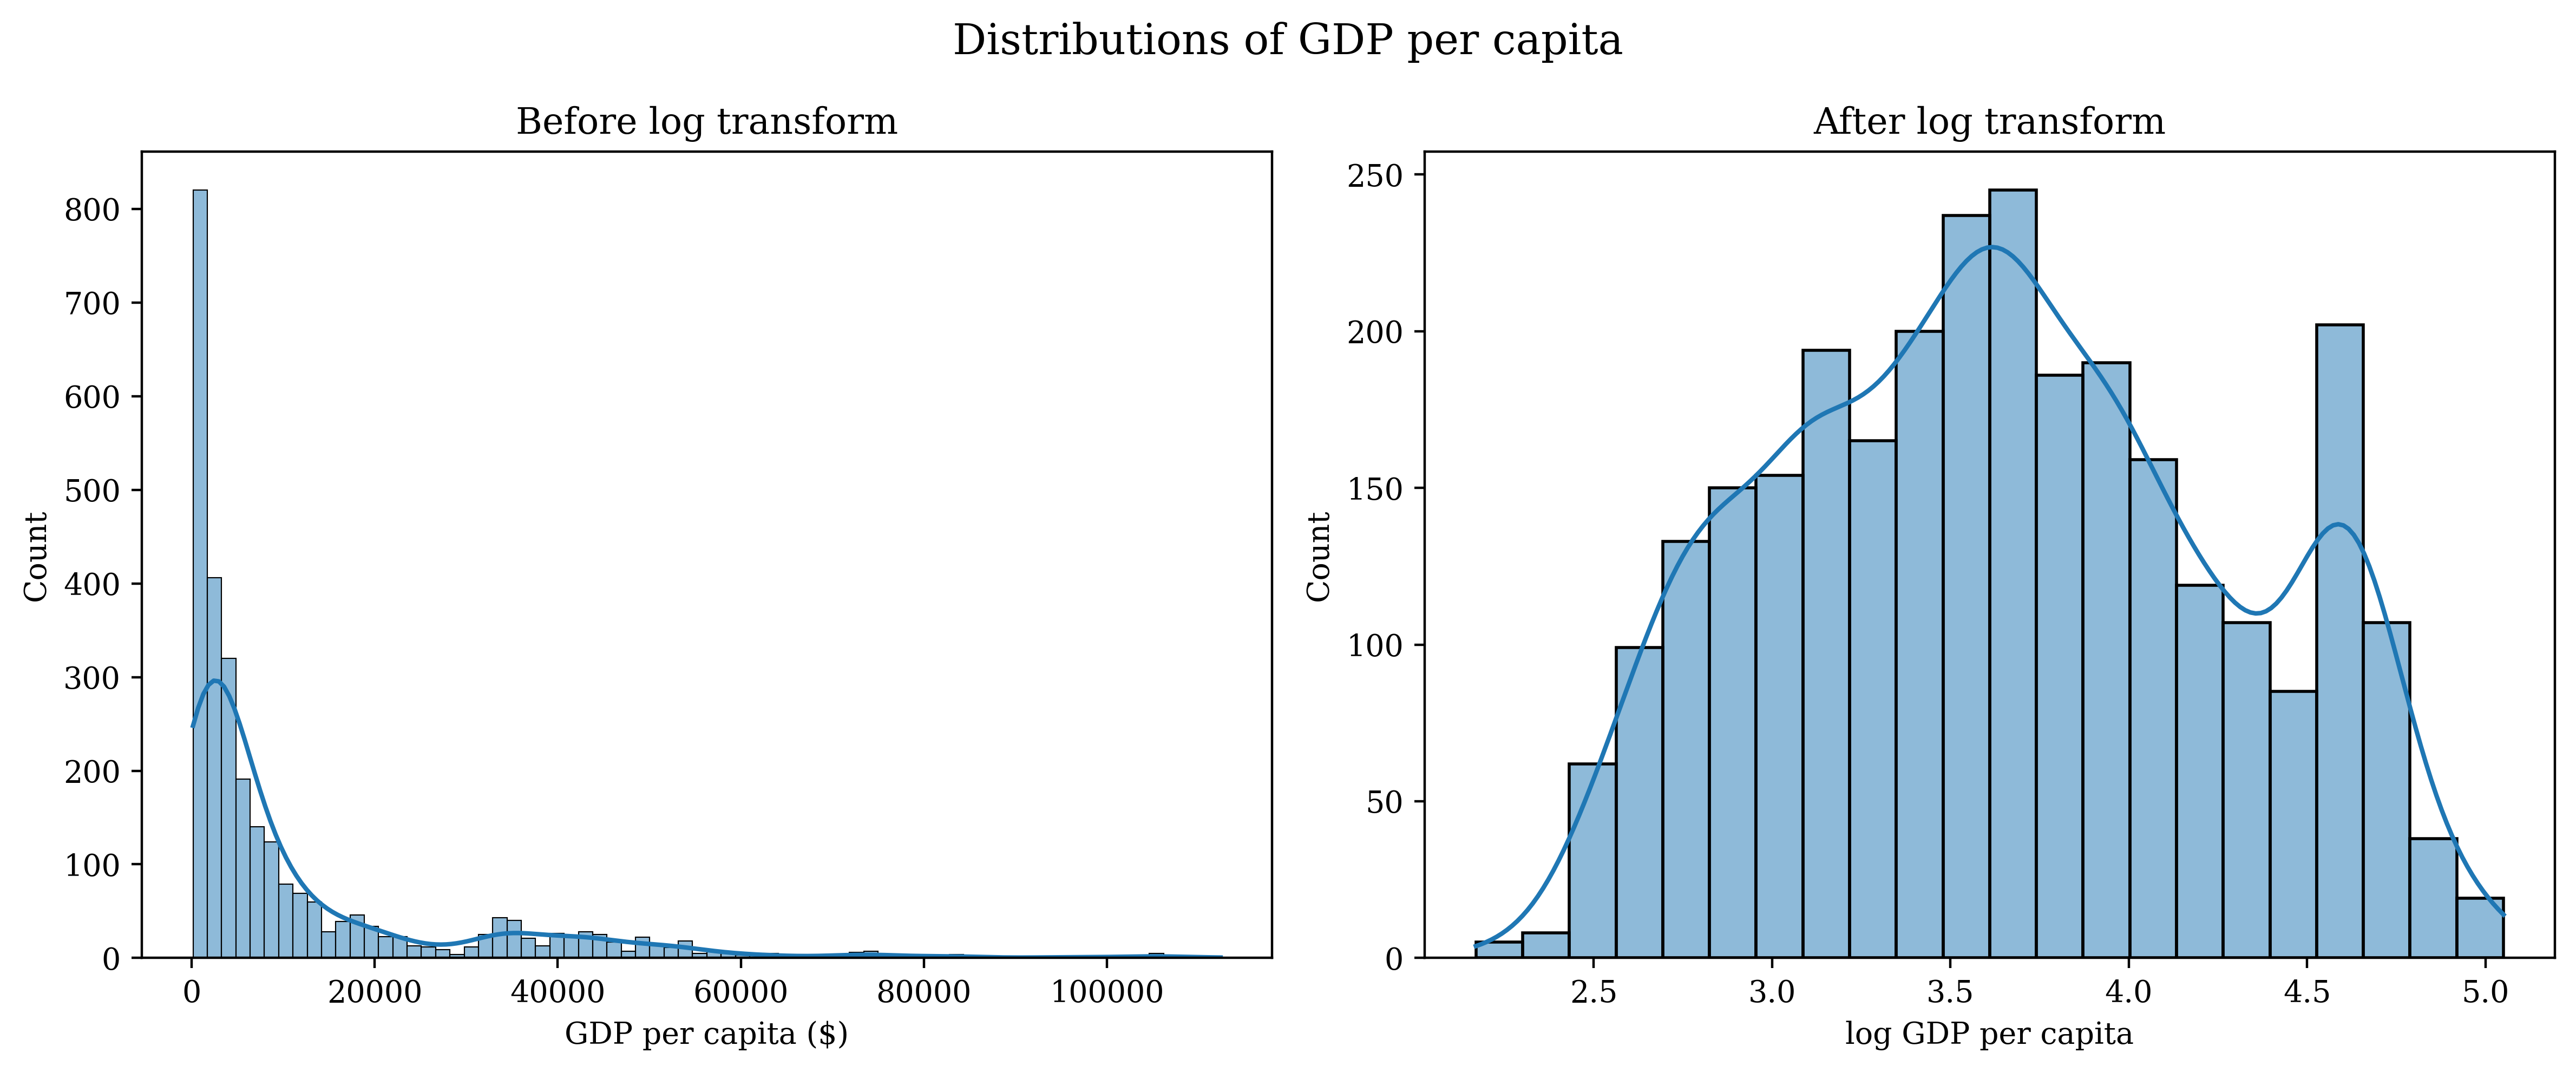

In [376]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))


sns.histplot(data=data, x="GDP per capita ($)" , ax=ax1, kde=True)
ax1.set_title("Before log transform")
sns.histplot(data=data, x="log GDP per capita" , ax=ax2, kde=True)
ax2.set_title("After log transform")
fig.suptitle("Distributions of GDP per capita", fontsize=14)
plt.tight_layout()
plt.show()

## Distributions

In [186]:
average_by_country = (data
                       .groupby(['Continent', 'Country'])
                       .mean(numeric_only=True)
                       .reset_index()
                       .drop(columns=["Year", "GDP per capita ($)", "Population (millions)"]))

In [383]:
def yearly_average_pairplot(df):
    g = sns.pairplot(df, hue="Continent", palette="hls", corner=True)
    g.fig.suptitle(f"Pairplot of all features", fontsize=24)

    legend = g._legend
    plt.setp(legend.get_texts(), fontsize='20')  # Set legend text fontsize
    plt.setp(legend.get_title(), fontsize='22')  # Set legend title fontsize
    plt.show()

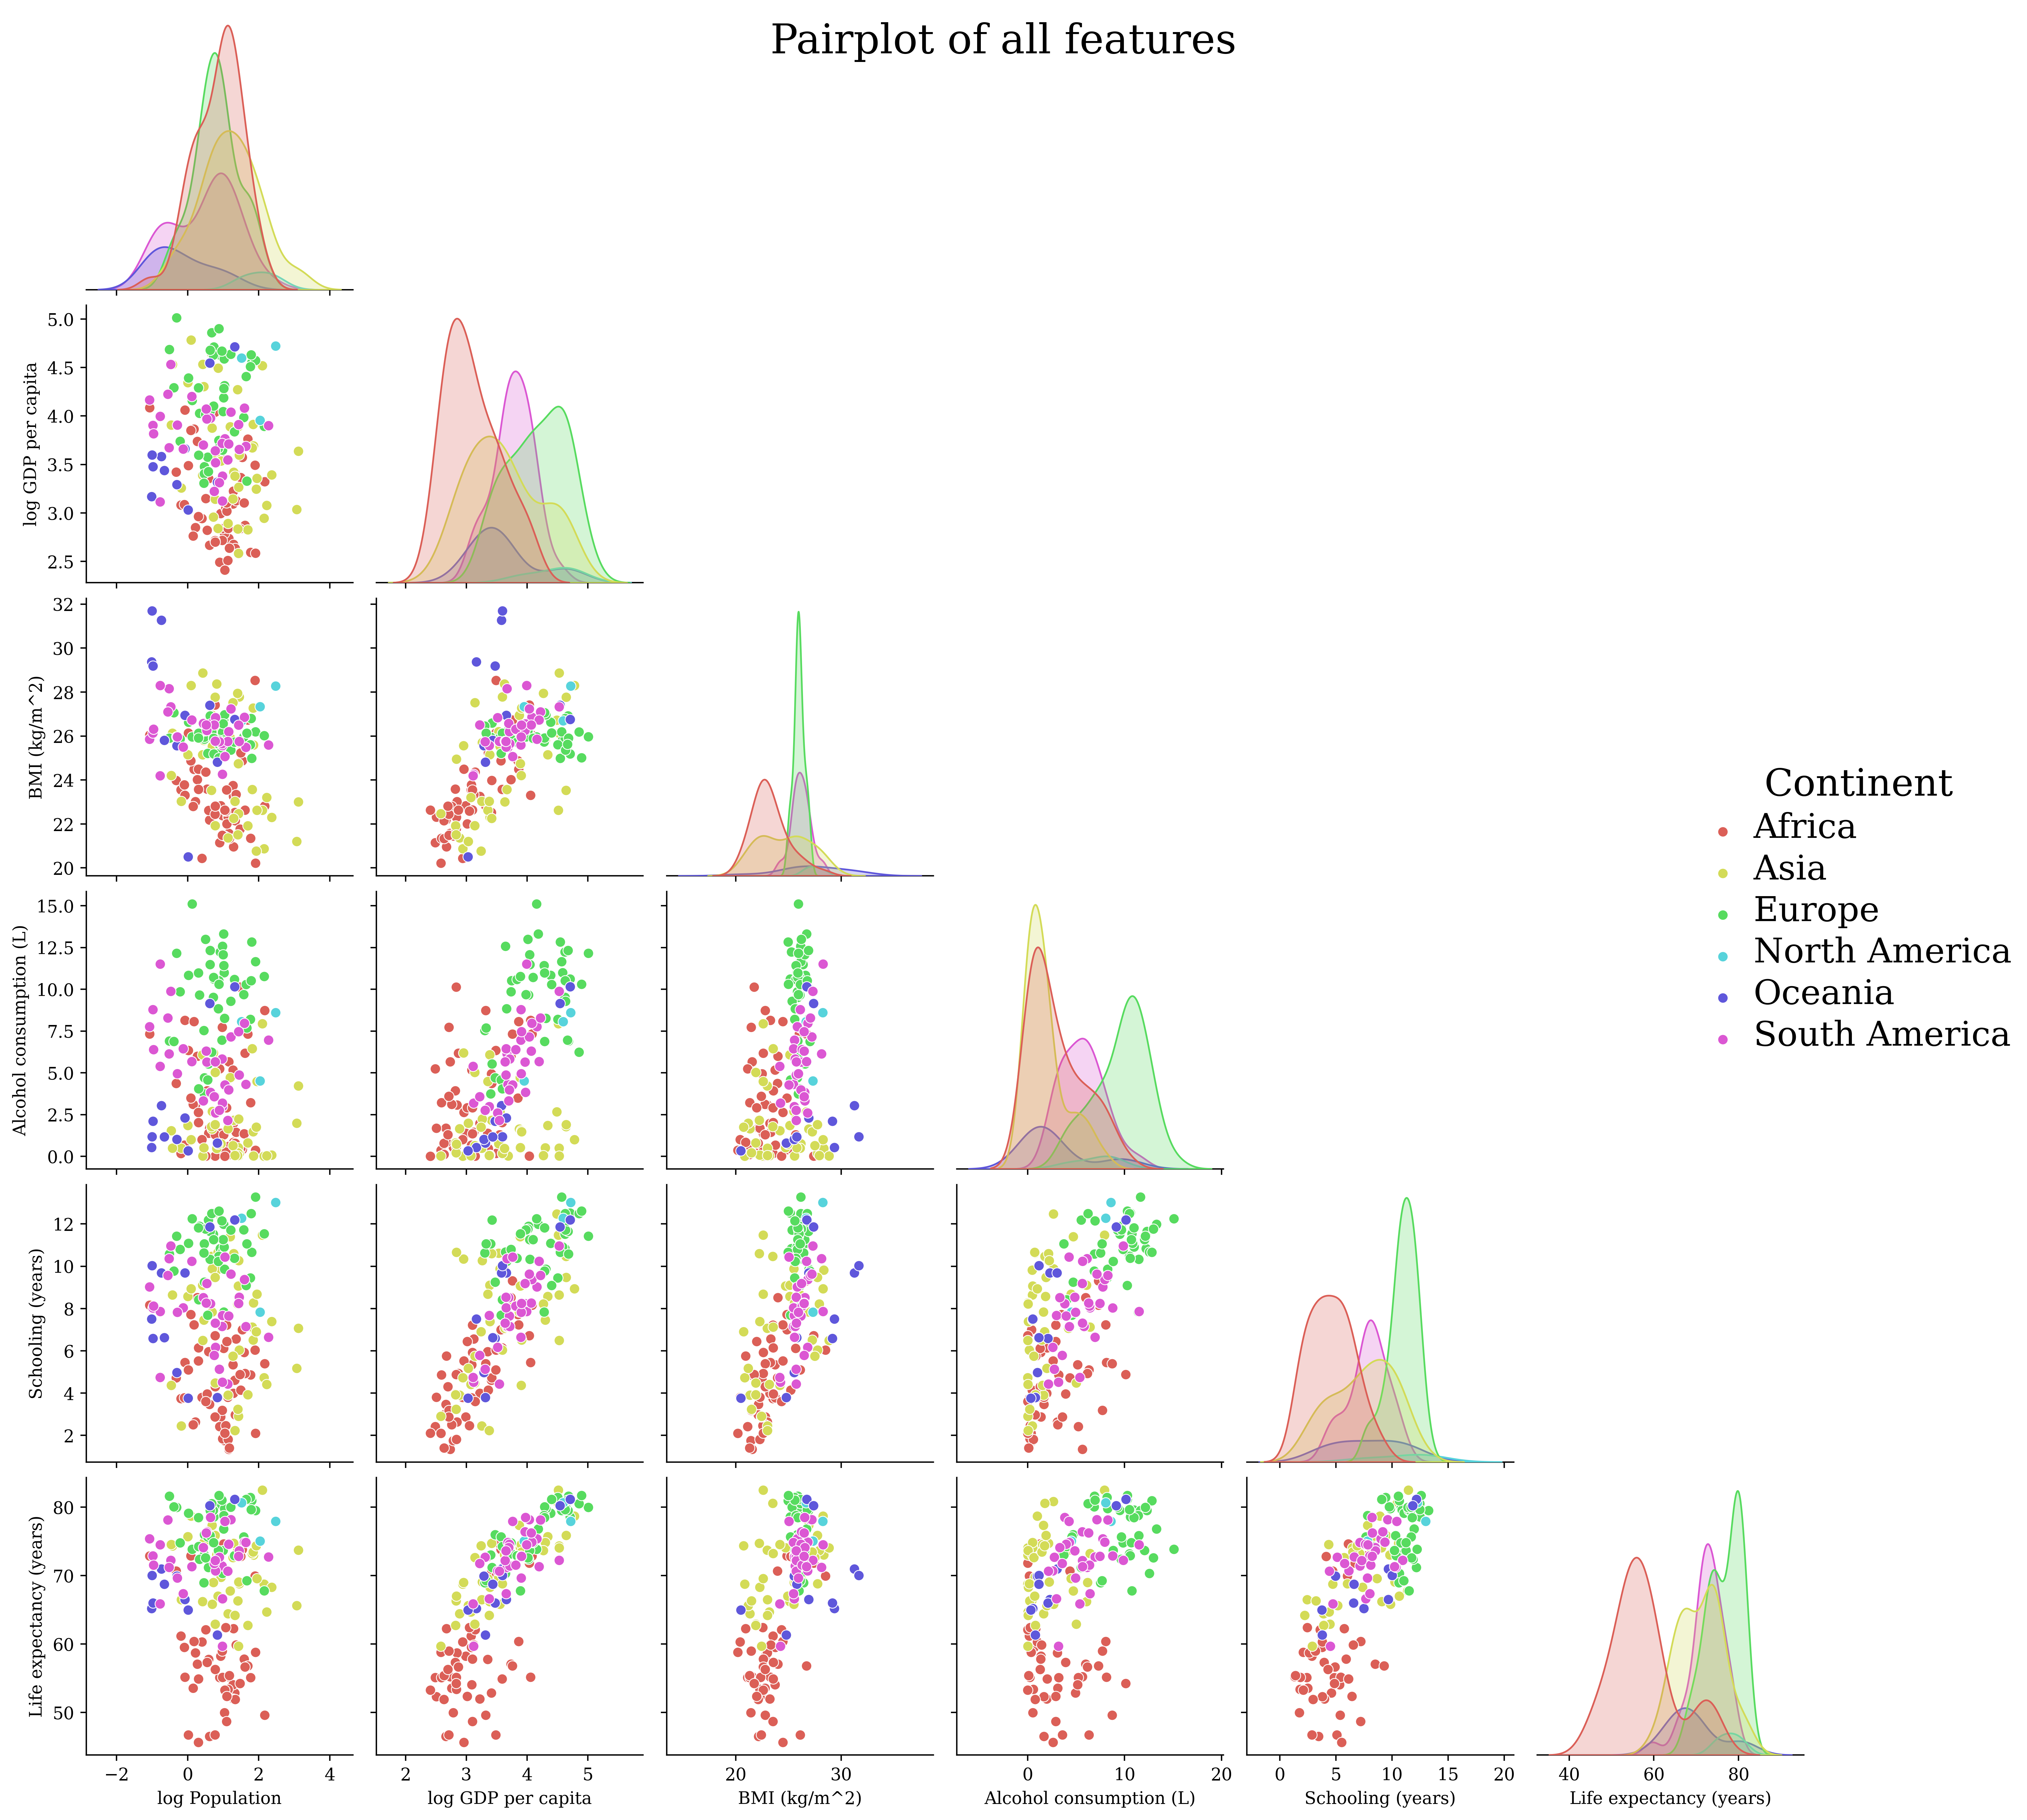

In [384]:
yearly_average_pairplot(average_by_country)

### Continents

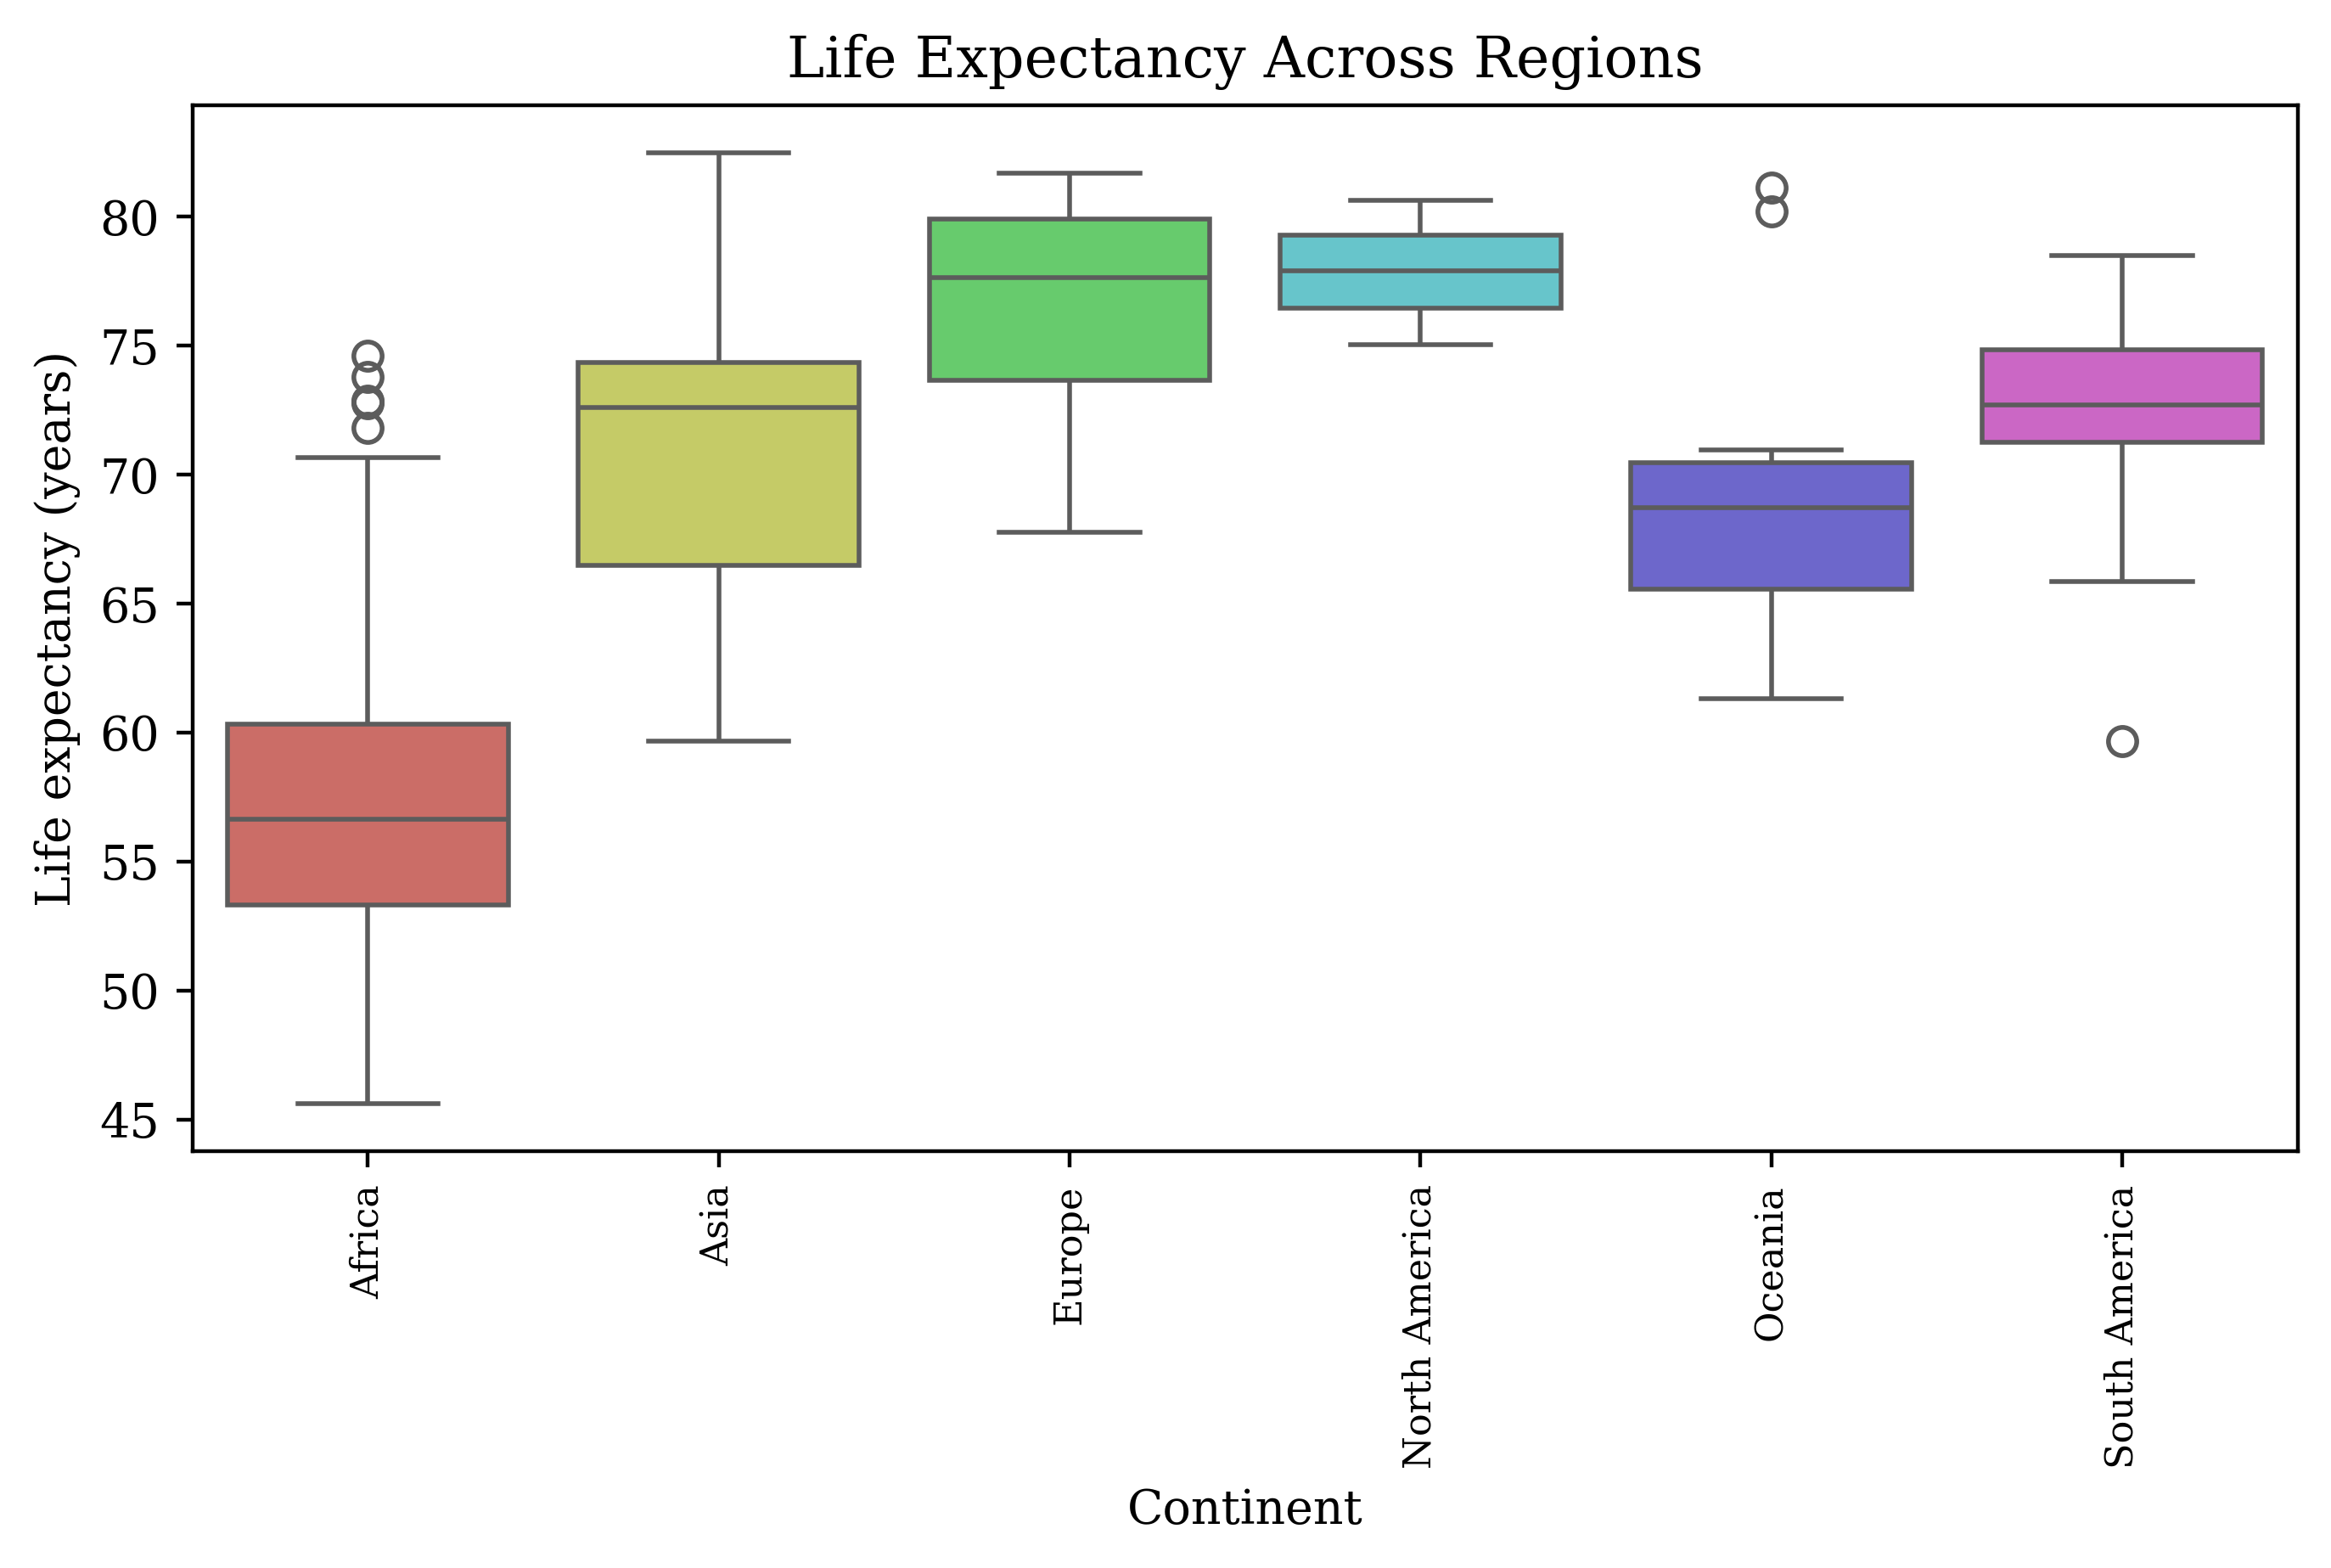

In [189]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Continent', y='Life expectancy (years)', data=average_by_country, palette='hls', hue='Continent')
plt.title("Life Expectancy Across Regions")
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [190]:
continents = ["Africa", "Asia", "Europe"]
cont_data = data[data["Continent"].isin(continents)]

In [354]:
def plot_yearly_feature_distribution(data, feature, year, ax=None, hue=None, palette=None):
    year_data = data[data["Year"] == year]
    if hue:
        sns.kdeplot(data=year_data, x=feature, ax=ax, hue=hue, palette=palette, fill=True, legend=False)  # Use consistent palette
    else:
        sns.histplot(data=year_data, x=feature, ax=ax)
    if ax:
        ax.set_title(f"{feature} distribution in {year}", fontsize=10)
    else:
        plt.title(f"{feature} distribution, {year}")
        plt.show()

In [359]:
import matplotlib.patches as mpatches
def plot_feature_distribution(data, feature, hue=None, mean=False):
    years = [2000, 2005, 2010, 2015]
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    
    # Define a custom color palette for the hue categories, ensuring consistent mapping
    if hue:
        unique_categories = data.groupby(hue)[feature].mean().sort_values().index  # Ensure consistent order
        colors = sns.color_palette("hls", len(unique_categories))
        palette = dict(zip(unique_categories, colors))  # Create a mapping of category -> color

    for i in range(len(years)):
        plot_yearly_feature_distribution(data, feature, years[i], ax=axes[i // 2, i % 2], hue=hue, palette=palette)
        if mean:
            for category in unique_categories:
                category_mean = data[data[hue] == category][feature].mean()
                axes[i // 2, i % 2].axvline(x=category_mean, color=palette[category], ls='--', lw=1, label=f"{category} mean")
    
    # Create custom legend manually with consistent colors
    if hue:
        patches = [mpatches.Patch(color=palette[cat], label=cat, alpha=0.5) for cat in unique_categories]
        
        # Position the legend below the title
        fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=len(unique_categories), title=hue)

    fig.suptitle(f"{feature} distributions across years", y=1.06)  # Move title up
    plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust layout to prevent overlap
    plt.subplots_adjust(top=0.88)  # Add extra space at the top
    plt.show()

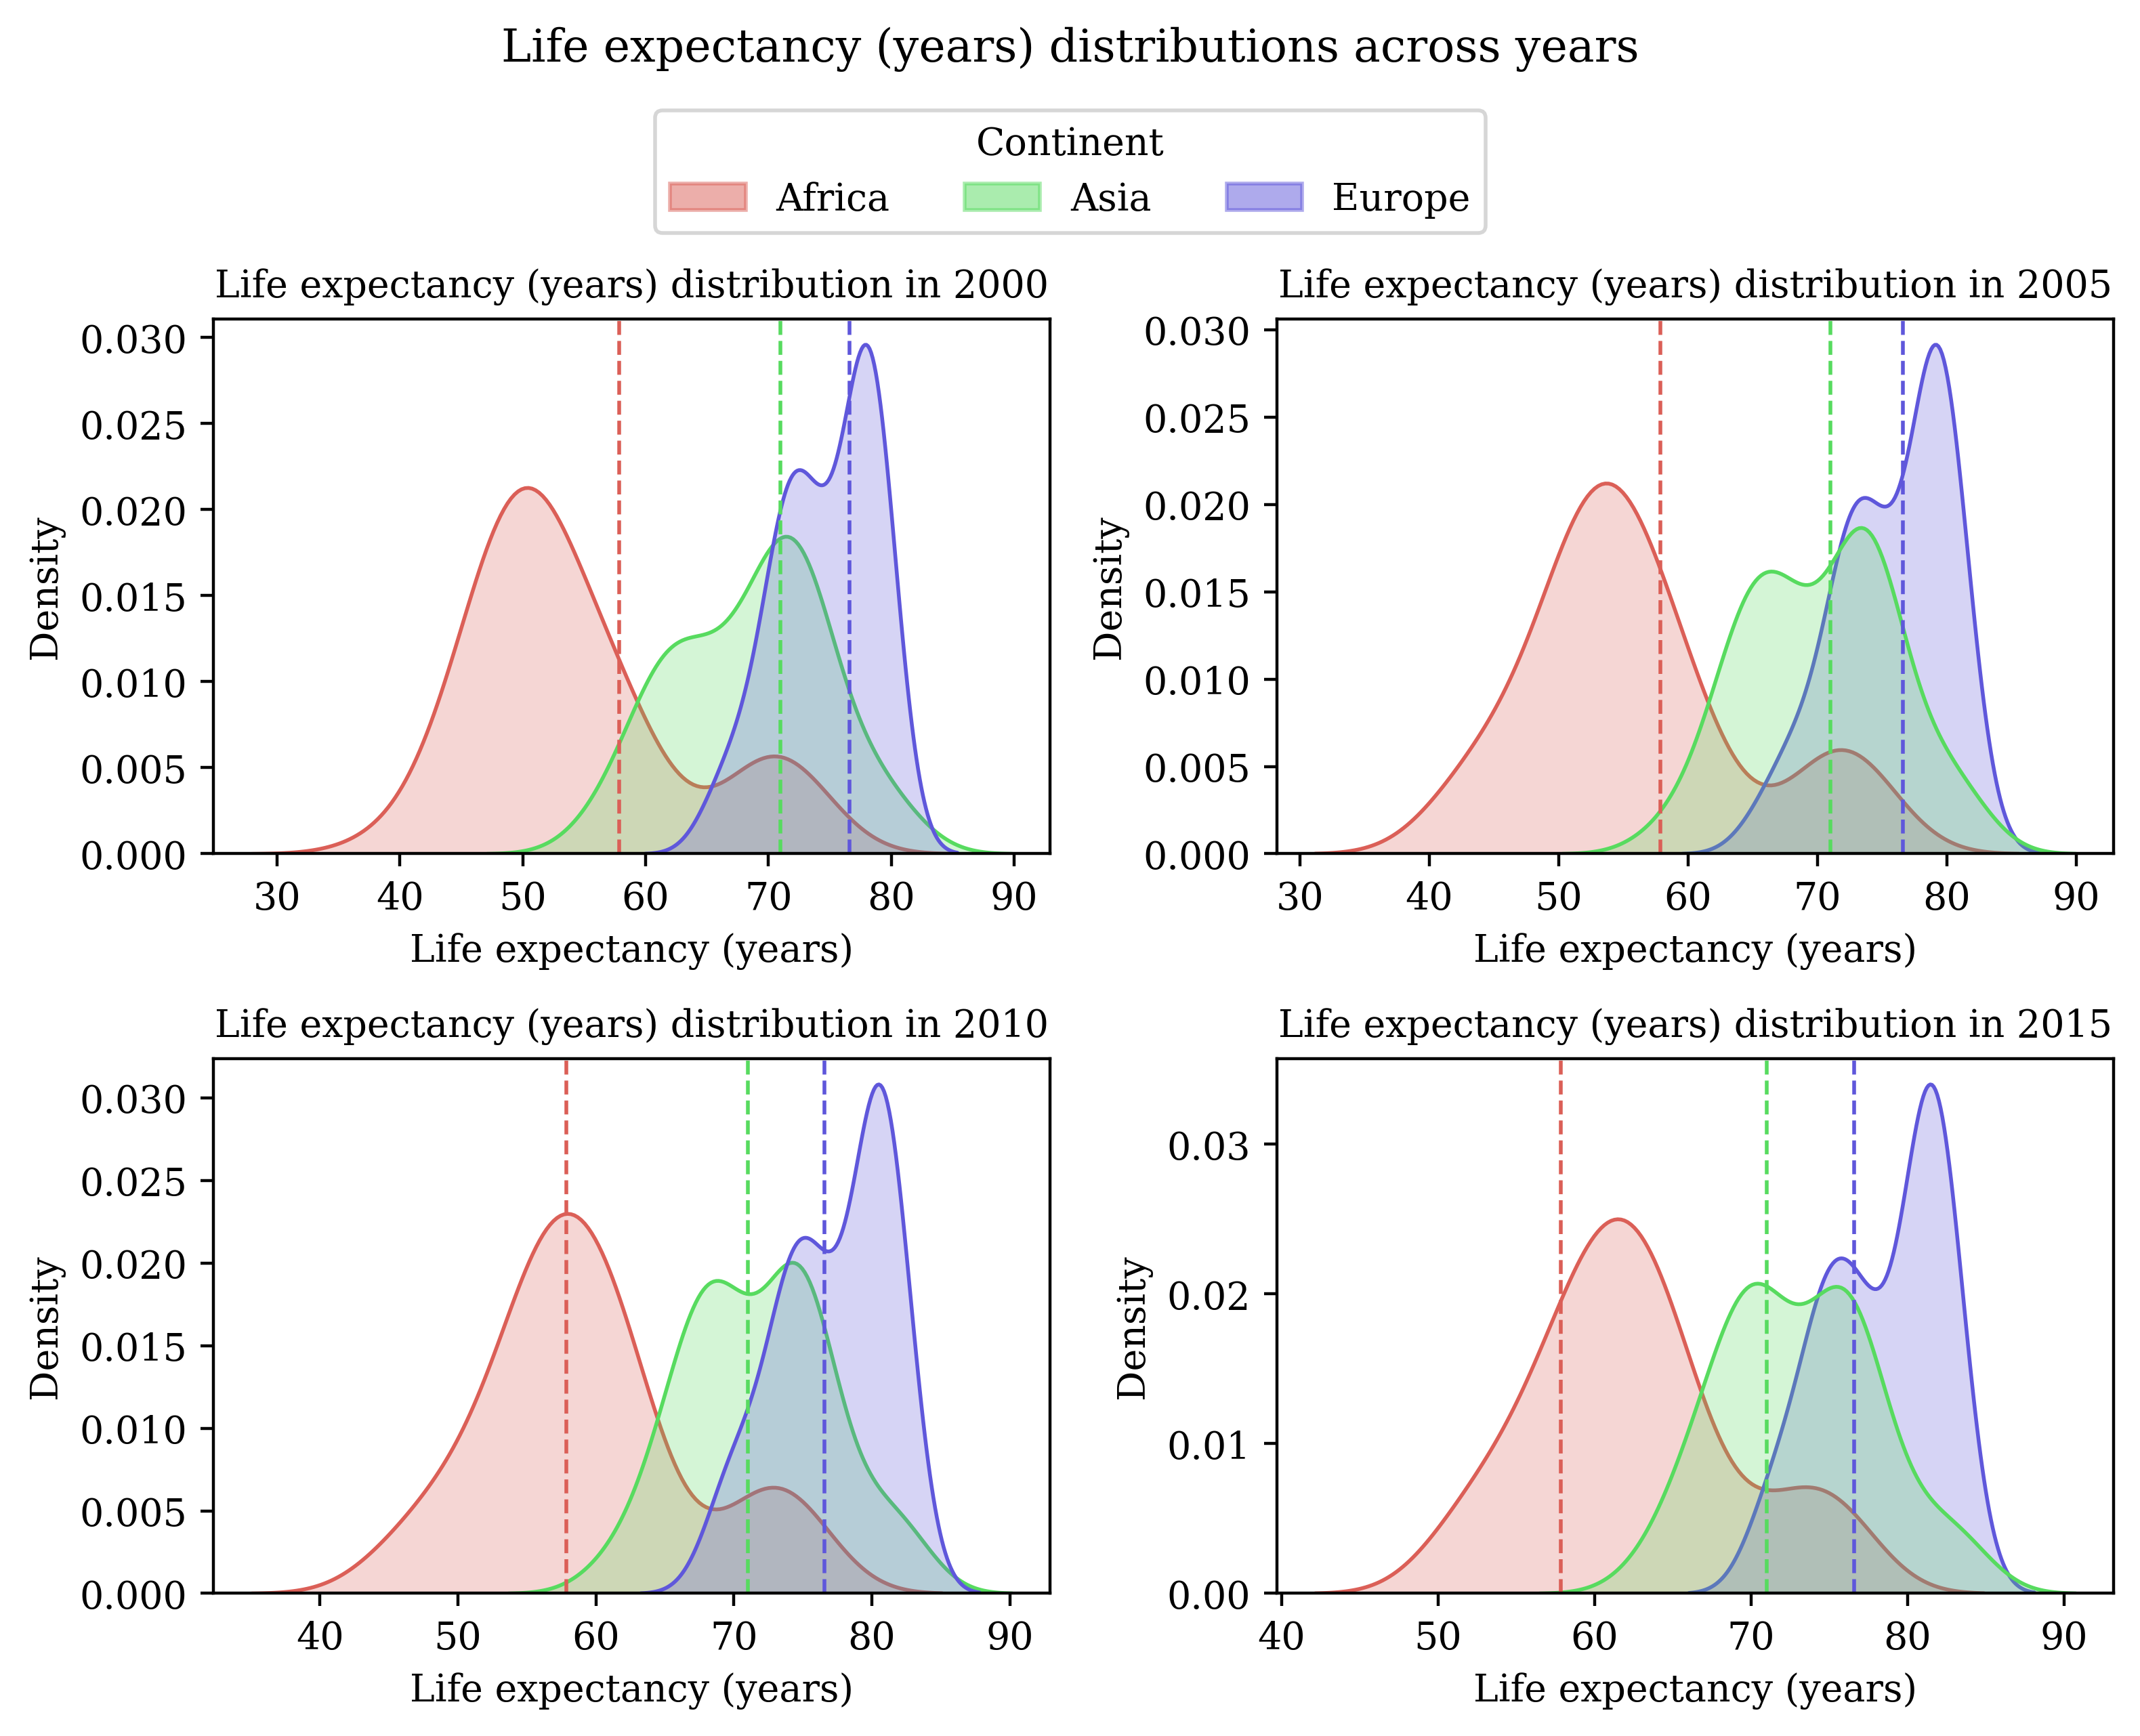

In [362]:
plot_feature_distribution(cont_data, "Life expectancy (years)", "Continent", mean=True)

In [194]:
SELECTED_FEATURE_TO_TEST = "Life expectancy (years)"
SELECTED_COLUMN = "Year"
YEARS = [2000, 2005, 2010, 2015]
cont_indices_list = ["Continent", "Country"]

#### Normality

$H_{0}$: The data is normally distributed.  
$H_{1}$: The data is not normally distributed.   

In [195]:
continents_normality_dfs = []
for continent in continents:
    continents_normality_dfs.append(
        create_normality_test_df(
        data=data,
        indices_list=cont_indices_list, selected_index_value = continent,
        selected_column=SELECTED_COLUMN, selected_column_values_list=YEARS,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

continents_normality_df = pd.concat(continents_normality_dfs, keys=continents, names=["Continent"], axis=0)

In [196]:
continents_normality_df

Year  D value  p value Reject $H_0$
Continent                                       
Africa    0  2000    0.180    0.064           No
          1  2005    0.145    0.214           No
          2  2010    0.116    0.461           No
          3  2015    0.110    0.535           No
Asia      0  2000    0.105    0.716           No
          1  2005    0.125    0.501           No
          2  2010    0.121    0.545           No
          3  2015    0.116    0.598           No
Europe    0  2000    0.171    0.154           No
          1  2005    0.178    0.123           No
          2  2010    0.175    0.134           No
          3  2015    0.211    0.040           No

As can be seen in the above table, in those years the distribution of `Life expectancy` in all continents is normal.

Now, we will have to check that all samples of distributions have the same variance in order to use parametric test.

#### Variance Homogeneity

$H_{0}$: The variances of the samples are same.  
$H_{1}$: The variances of the samples are different.

In [197]:
variance_homogeneity_df = create_variance_homogeneity_test_df(data,
                              indices_list = cont_indices_list,
                              selected_index_values=continents,
                              selected_column=SELECTED_COLUMN, selected_column_values=YEARS,
                              selected_feature_to_test=SELECTED_FEATURE_TO_TEST)
variance_homogeneity_df

Year  W value  p value Reject $H_0$
0  2000    4.186    0.017           No
1  2005    3.775    0.025           No
2  2010    3.696    0.027           No
3  2015    3.071    0.050           No

Therefore, The variances are same.

Now, We can continue and use T-test.


#### Independent 2 Sample T-Test

$H_{0}^{1}$: $\mu_{Asia}\le \mu_{Africa}$     
$H_{0}^{2}$: $\mu_{Europe} \le  \mu_{Asia}$

We use the T-test, since we do not know the standard deviation of the samples.

In addition, we use a one-sided test since we have a priori assumptions regarding the relation between continent and life expectancy.

In [198]:
continent_pairs = [("Asia", "Africa"), ("Europe", "Asia")]
continents_t_dfs = []
for year in YEARS:
    continents_t_dfs.append(
        create_independent_2_sample_t_test_df(
        data=data,
        indices_list=cont_indices_list, selected_index_values_pairs_list = continent_pairs,
        selected_column=SELECTED_COLUMN, selected_column_value=year,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

continents_t_df = pd.concat(continents_t_dfs, keys=YEARS, names=["Year"], axis=0)

In [199]:
continents_t_df

$H_0$  T value  p value (one-sided)  \
Year                                                                   
2000 0  $\mu_{Asia} \leq \mu_{Africa}$    9.208                  0.0   
     1  $\mu_{Europe} \leq \mu_{Asia}$    5.439                  0.0   
2005 0  $\mu_{Asia} \leq \mu_{Africa}$    9.447                  0.0   
     1  $\mu_{Europe} \leq \mu_{Asia}$    5.068                  0.0   
2010 0  $\mu_{Asia} \leq \mu_{Africa}$    9.201                  0.0   
     1  $\mu_{Europe} \leq \mu_{Asia}$    5.388                  0.0   
2015 0  $\mu_{Asia} \leq \mu_{Africa}$    8.783                  0.0   
     1  $\mu_{Europe} \leq \mu_{Asia}$    5.616                  0.0   

       Reject $H_0$  
Year                 
2000 0          Yes  
     1          Yes  
2005 0          Yes  
     1          Yes  
2010 0          Yes  
     1          Yes  
2015 0          Yes  
     1          Yes

### GDP per capita

In [200]:
data.insert(7, "GDP category", pd.cut(data['log GDP per capita'], bins=3, labels=['low', 'medium', 'high']))

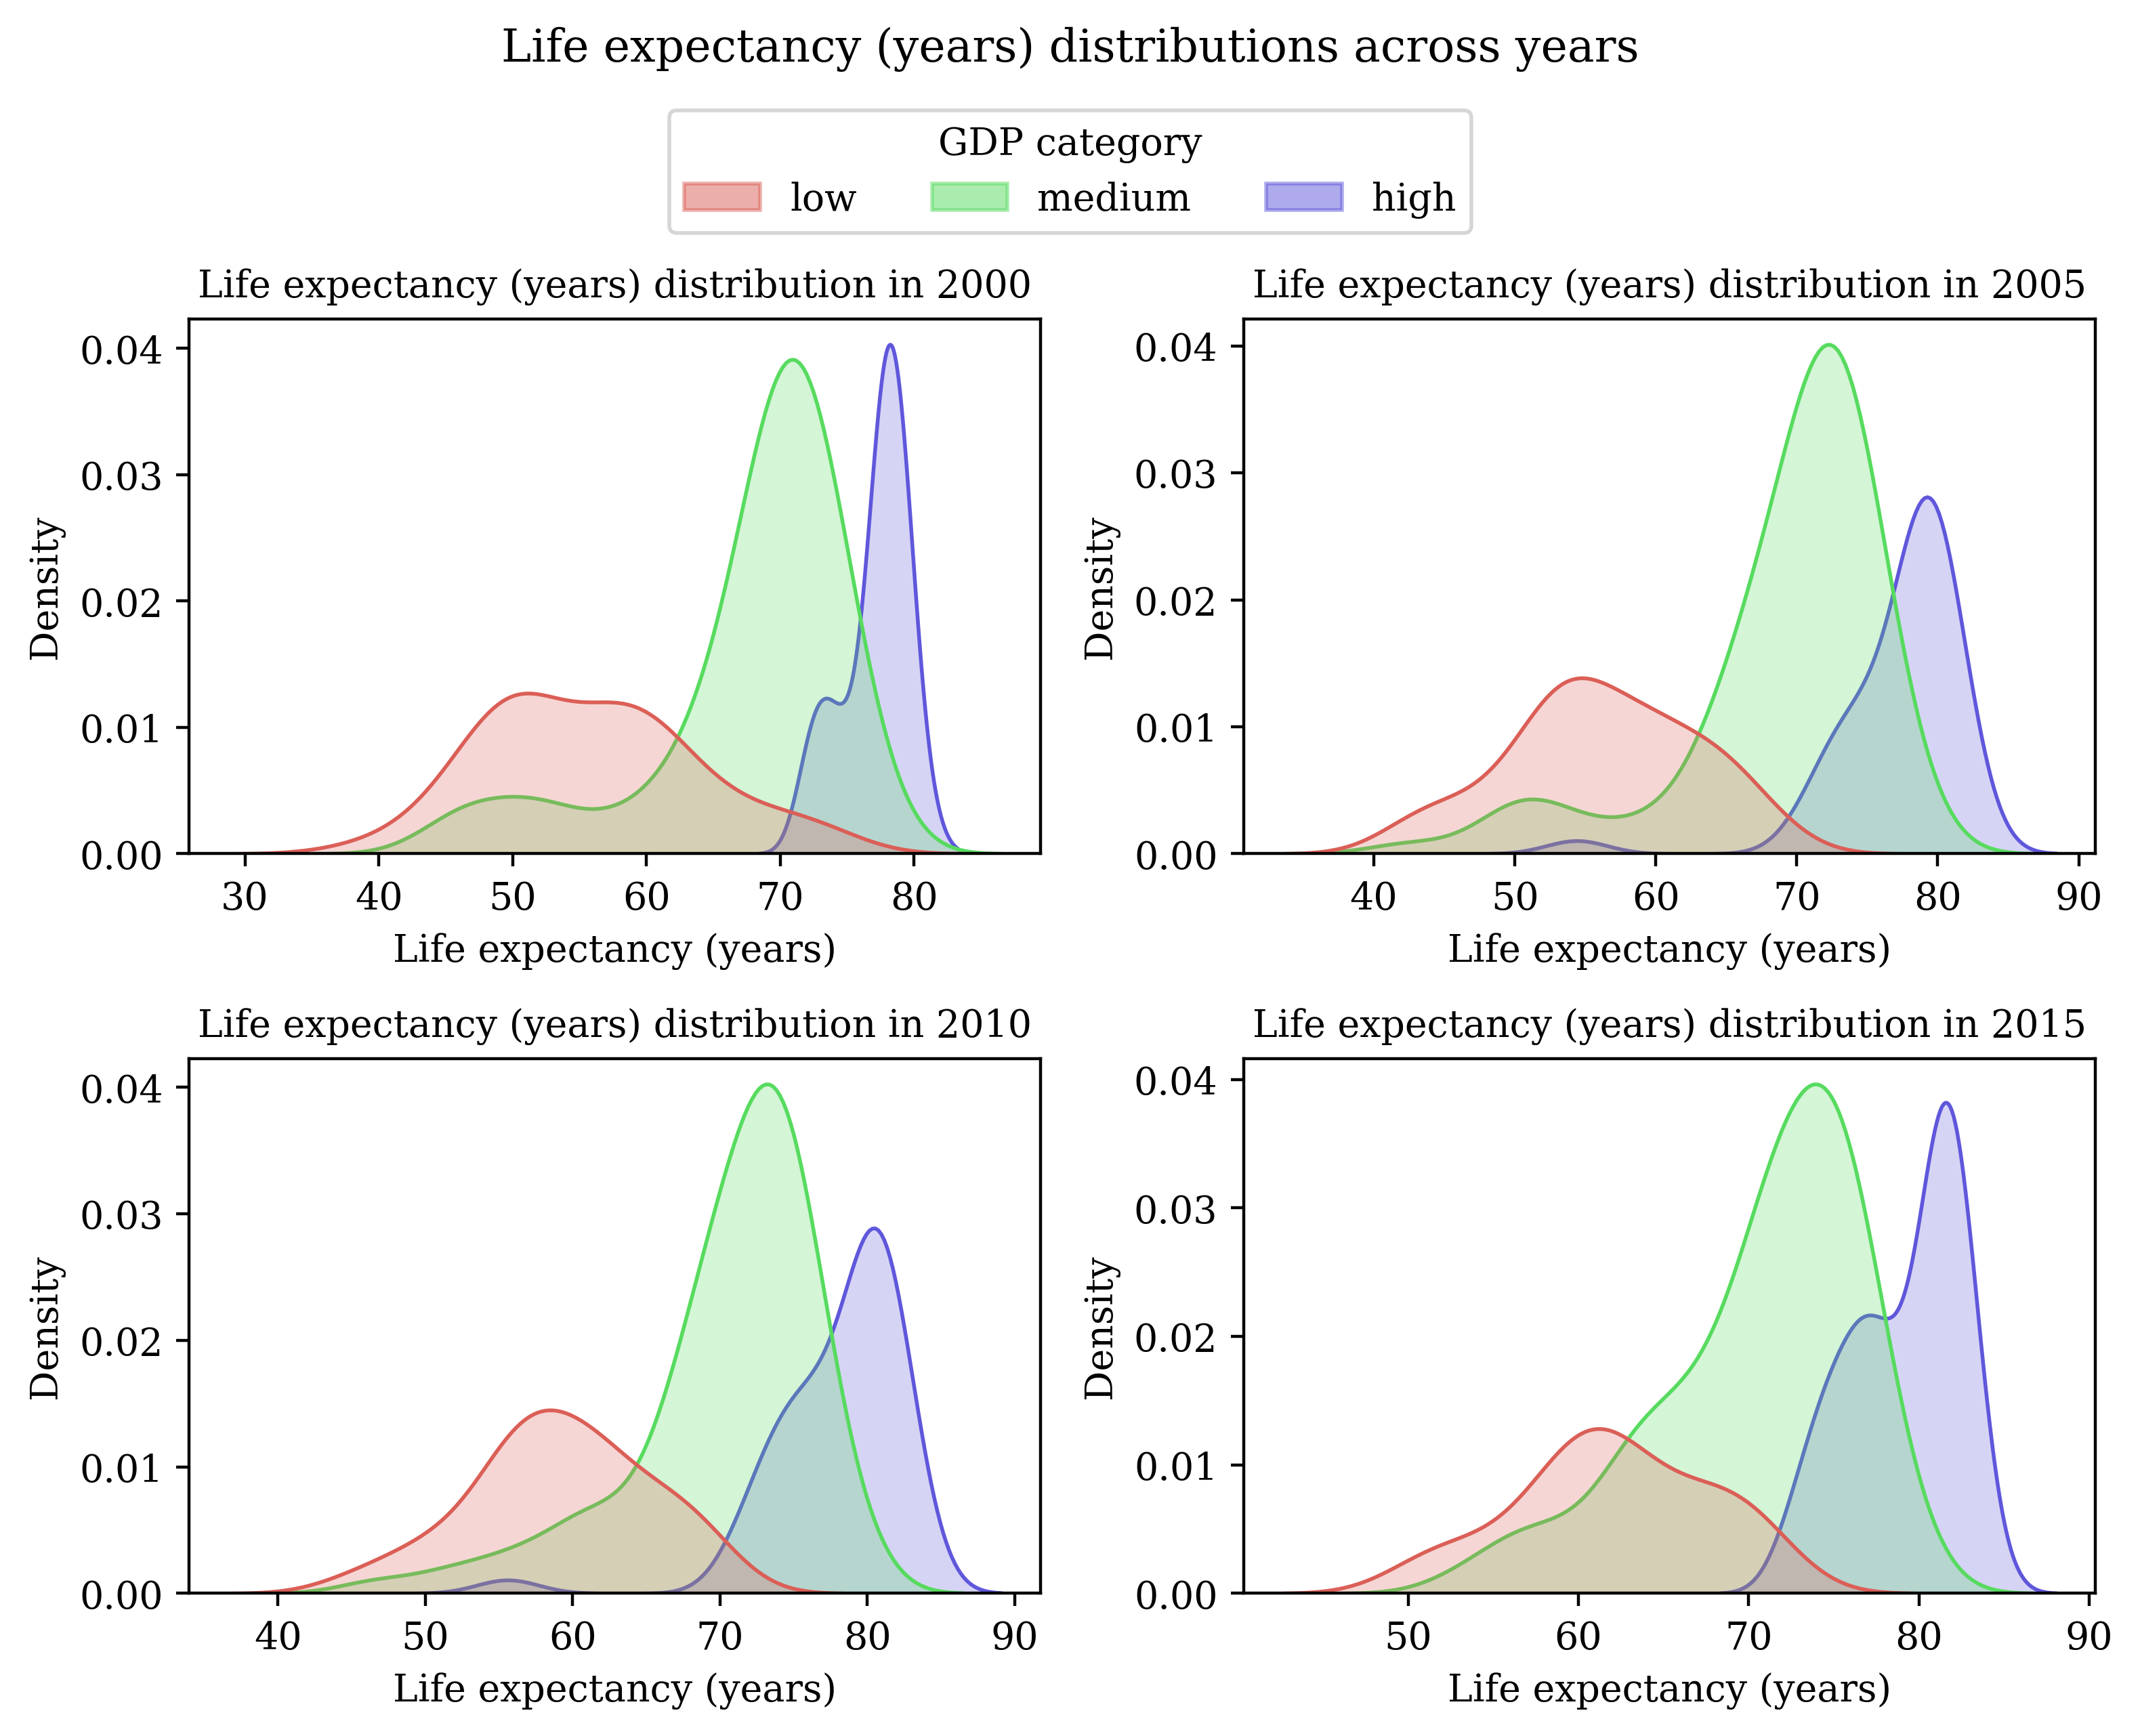

In [201]:
plot_feature_distribution(data, "Life expectancy (years)", hue="GDP category")

In [202]:
gdp_indices_list = ["GDP category", "Country"]

#### Normality
$H_{0}$: The data is normally distributed.  
$H_{1}$: The data is not normally distributed.   

In [203]:
gdp_categories = ["low", "medium", "high"]
gdp_categories_normality_dfs = []
for category in gdp_categories:
    gdp_categories_normality_dfs.append(
        create_normality_test_df(
        data=data,
        indices_list=gdp_indices_list, selected_index_value = category,
        selected_column=SELECTED_COLUMN, selected_column_values_list=YEARS,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

gdp_categories_normality_df = pd.concat(gdp_categories_normality_dfs, keys=gdp_categories, names=["Category"], axis=0)

In [204]:
gdp_categories_normality_df

Year  D value  p value Reject $H_0$
Category                                       
low      0  2000    0.124    0.378           No
         1  2005    0.065    0.984           No
         2  2010    0.067    0.985           No
         3  2015    0.079    0.970           No
medium   0  2000    0.221    0.000          Yes
         1  2005    0.176    0.006          Yes
         2  2010    0.139    0.057           No
         3  2015    0.127    0.096           No
high     0  2000    0.194    0.100           No
         1  2005    0.218    0.028           No
         2  2010    0.171    0.108           No
         3  2015    0.177    0.068           No

#### Variance Homogeneity

$H_{0}$: The variances of the samples are same.  
$H_{1}$: The variances of the samples are different.

In [205]:
gdp_variance_homogeneity_df = create_variance_homogeneity_test_df(data,
                              indices_list = gdp_indices_list,
                              selected_index_values=gdp_categories,
                              selected_column=SELECTED_COLUMN, selected_column_values=YEARS,
                              selected_feature_to_test=SELECTED_FEATURE_TO_TEST)
gdp_variance_homogeneity_df

Year  W value  p value Reject $H_0$
0  2000    9.514    0.000          Yes
1  2005    3.289    0.040           No
2  2010    2.143    0.120           No
3  2015    4.959    0.008          Yes

Since in some years the distribution is normal with equal variance, while in others it isn't, we'll use the T-test and U-test accordingly.

In [206]:
t_years = [2010]
u_years = [2000 , 2005, 2015]

#### Independent 2-sample T-test

$H_{0}^1: \mu_{\text{medium GDP}} \le \mu_{\text{low GDP}}$

$H_{0}^2: \mu_{\text{high GDP}} \le \mu_{\text{medium GDP}}$

$H_{0}^3: \mu_{\text{high GDP}} \le \mu_{\text{low GDP}}$

  
We will use a one-sided test since we have a priori assumptions regarding the relation between gdp and life expectancy.

In [207]:
gdp_categories_pairs = [("medium", "low"), ("high", "medium"), ("high", "low")]
gdp_categories_t_dfs = []

for year in t_years:
    gdp_categories_t_dfs.append(
        create_independent_2_sample_t_test_df(
        data=data,
        indices_list=gdp_indices_list, selected_index_values_pairs_list = gdp_categories_pairs,
        selected_column=SELECTED_COLUMN, selected_column_value=year,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

gdp_categories_t_df = pd.concat(gdp_categories_t_dfs, keys=t_years, names=["Year"], axis=0)

In [208]:
gdp_categories_t_df

$H_0$  T value  p value (one-sided)  \
Year                                                                   
2010 0   $\mu_{medium} \leq \mu_{low}$    9.586                  0.0   
     1  $\mu_{high} \leq \mu_{medium}$    7.454                  0.0   
     2     $\mu_{high} \leq \mu_{low}$   16.849                  0.0   

       Reject $H_0$  
Year                 
2010 0          Yes  
     1          Yes  
     2          Yes

#### Independent Mann-Whitney U rank Test

$H_{0}^1: \text{median}_{\text{medium GDP}} \le \text{median}_{\text{low GDP}}$

$H_{0}^2: \text{median}_{\text{high GDP}} \le \text{median}_{\text{medium GDP}}$

$H_{0}^3: \text{median}_{\text{high GDP}} \le \text{median}_{\text{low GDP}}$

  
We will use a one-sided test since we have a priori assumptions regarding the relation between schooling and life expectancy.

In [209]:
gdp_categories_pairs = [("medium", "low"), ("high", "medium"), ("high", "low")]
gdp_categories_u_dfs = []

for year in u_years:
    gdp_categories_u_dfs.append(
        create_independent_Mann_Whitney_U_rank_test_df(
        data=data,
        indices_list=gdp_indices_list, selected_index_values_pairs_list = gdp_categories_pairs,
        selected_column=SELECTED_COLUMN, selected_column_value=year,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

gdp_categories_u_df = pd.concat(gdp_categories_u_dfs, keys=u_years, names=["Year"], axis=0)

In [210]:
gdp_categories_u_df

$H_0$  U value  \
Year                                                            
2000 0   $\text{med}_{medium} \leq \text{med}_{low}$   3953.5   
     1  $\text{med}_{high} \leq \text{med}_{medium}$   3272.5   
     2     $\text{med}_{high} \leq \text{med}_{low}$   1931.0   
2005 0   $\text{med}_{medium} \leq \text{med}_{low}$   3723.0   
     1  $\text{med}_{high} \leq \text{med}_{medium}$   3543.5   
     2     $\text{med}_{high} \leq \text{med}_{low}$   1909.0   
2015 0   $\text{med}_{medium} \leq \text{med}_{low}$   2764.5   
     1  $\text{med}_{high} \leq \text{med}_{medium}$   4408.5   
     2     $\text{med}_{high} \leq \text{med}_{low}$   1820.0   

        p value (one-sided) Reject $H_0$  
Year                                      
2000 0                  0.0          Yes  
     1                  0.0          Yes  
     2                  0.0          Yes  
2005 0                  0.0          Yes  
     1                  0.0          Yes  
     2                  0.0          Yes  
2015 0                  0.0          Yes  
     1                  0.0          Yes  
     2                  0.0          Yes

### BMI

In [211]:
data.insert(9, "BMI category", (data["BMI (kg/m^2)"] > 25).astype(int))

In [212]:
data.loc[data["BMI category"] == 0, "BMI category"] = "low"
data.loc[data["BMI category"] == 1, "BMI category"] = "high"

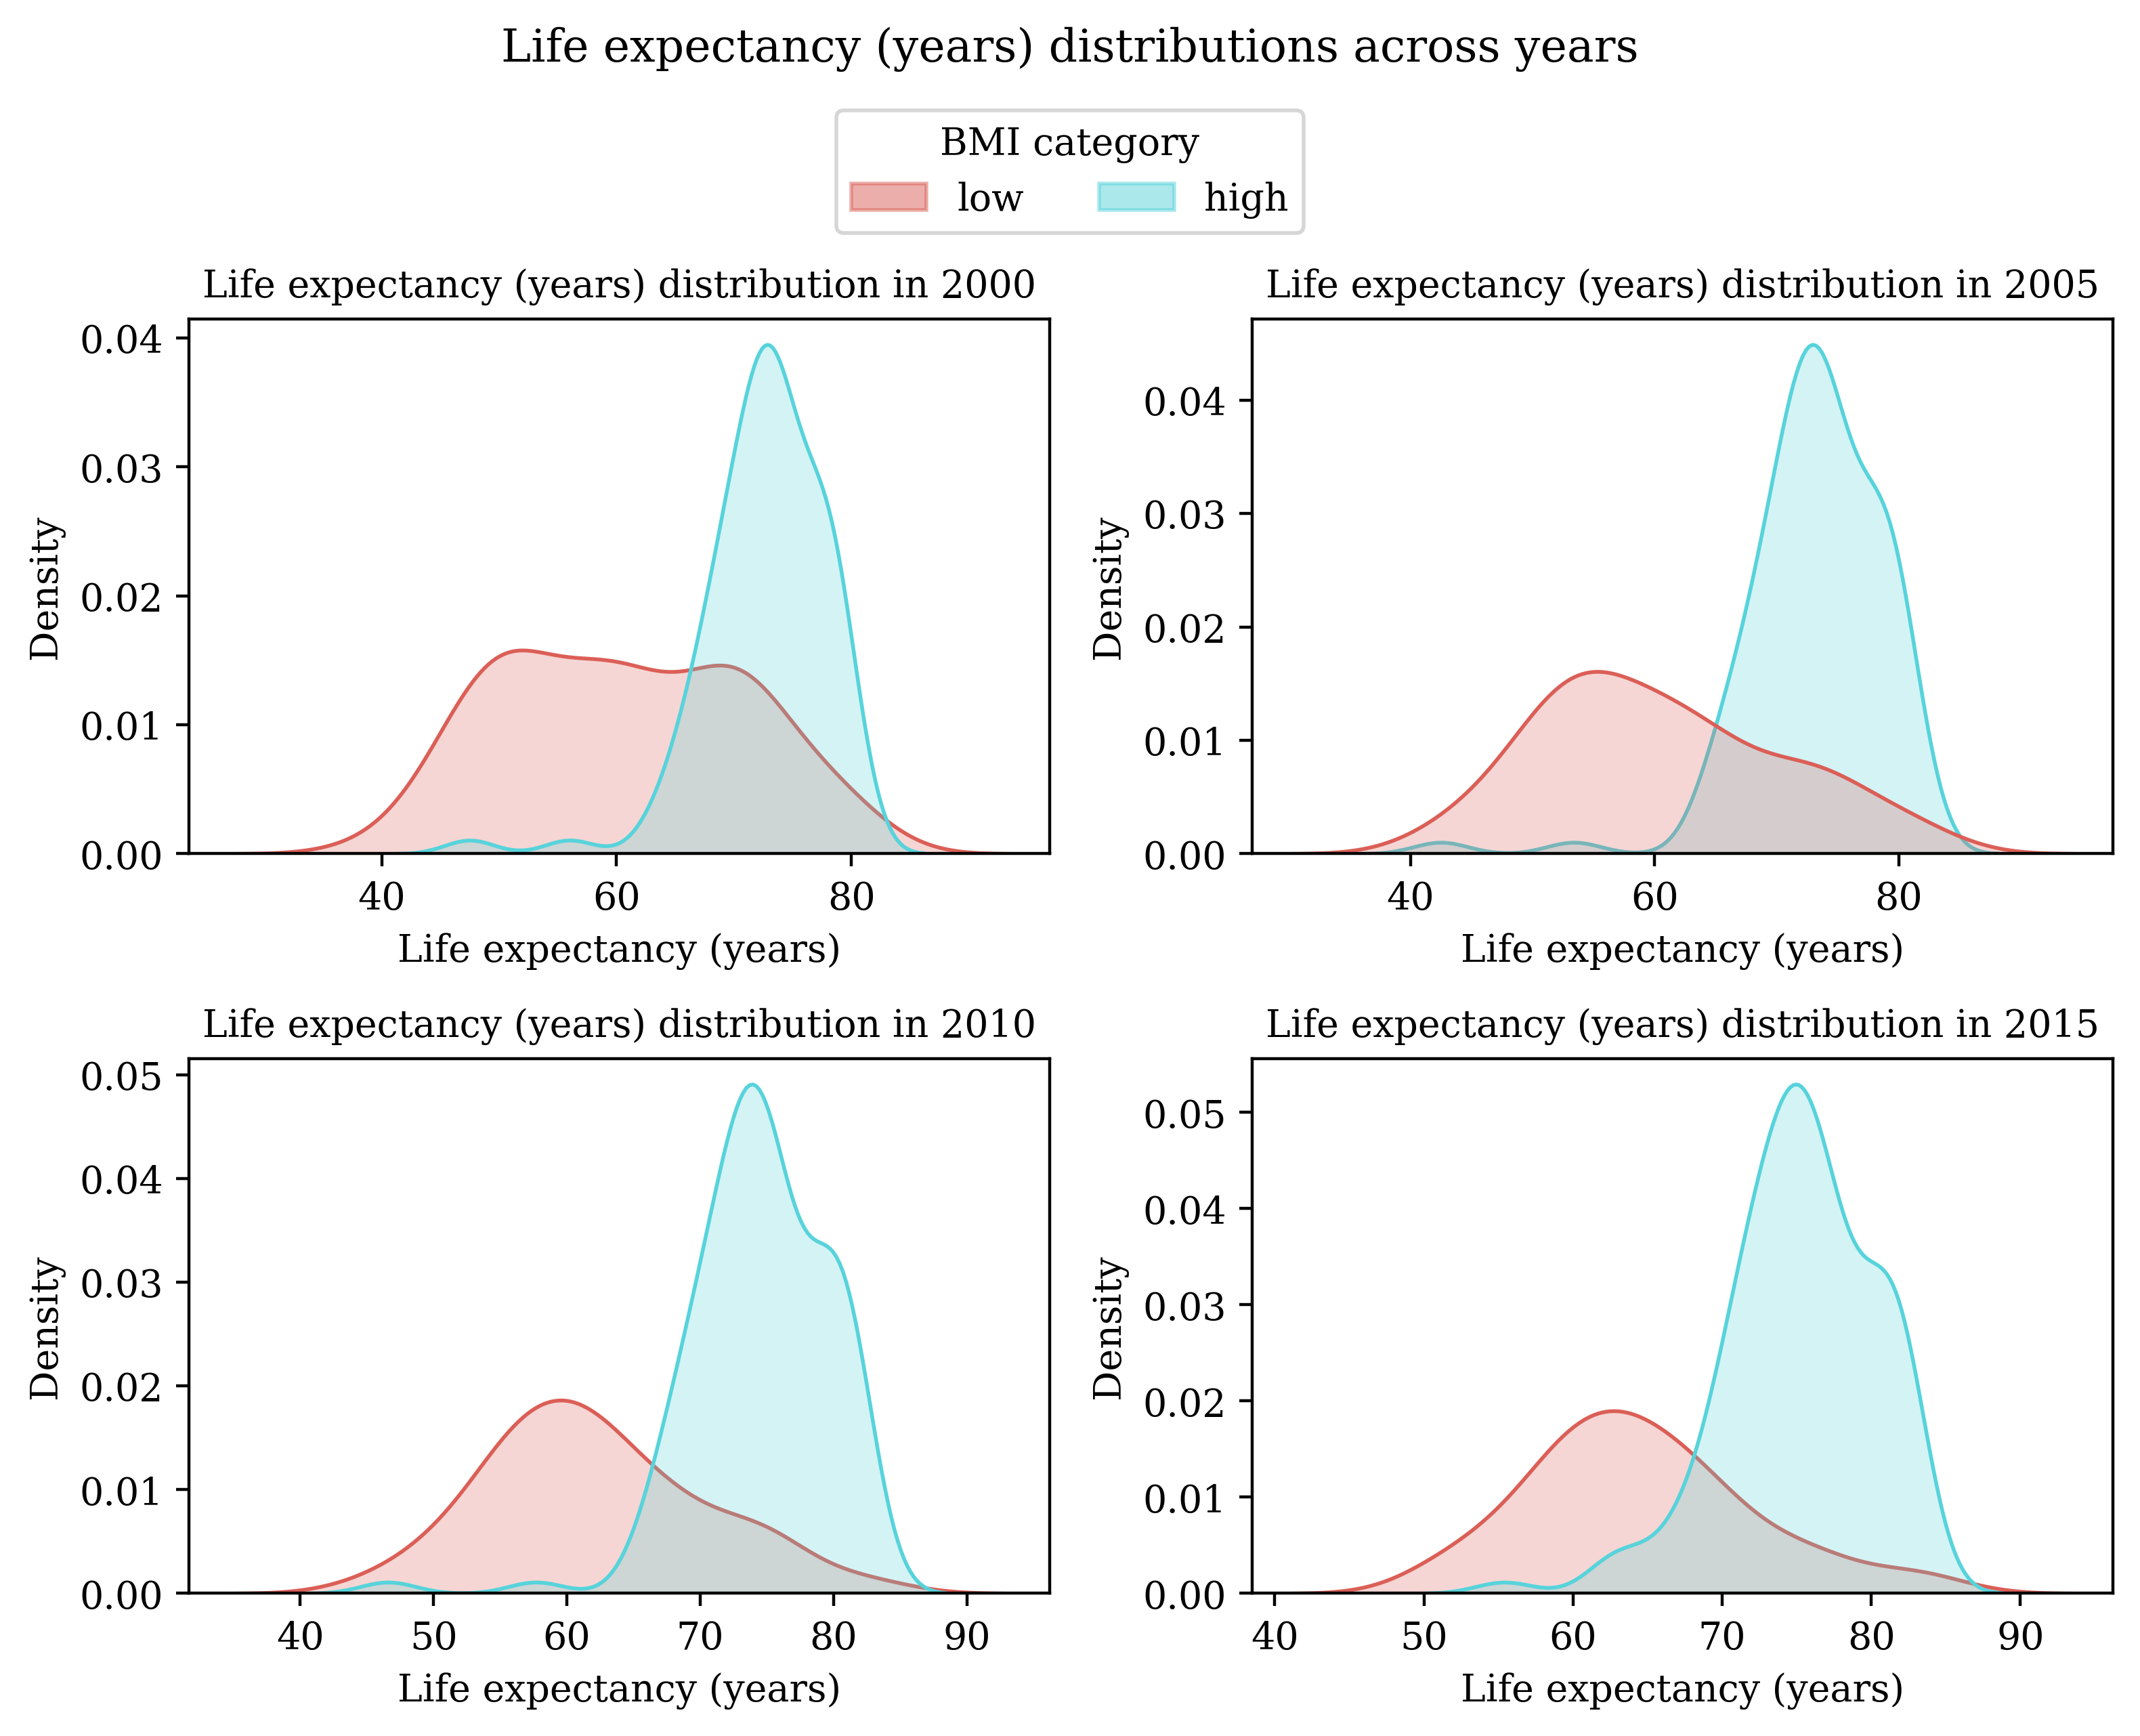

In [213]:
plot_feature_distribution(data, "Life expectancy (years)", hue="BMI category")

In [214]:
indices_list = ["BMI category", "Country"]

#### Normality
$H_{0}$: The data is normally distributed.  
$H_{1}$: The data is not normally distributed.   

In [215]:
bmi_categories = ["low", "high"]
bmi_categories_normality_dfs = []
for category in bmi_categories:
    bmi_categories_normality_dfs.append(
        create_normality_test_df(
        data=data,
        indices_list=indices_list, selected_index_value = category,
        selected_column=SELECTED_COLUMN, selected_column_values_list=YEARS,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

bmi_categories_normality_df = pd.concat(bmi_categories_normality_dfs, keys=bmi_categories, names=["Category"], axis=0)

In [216]:
bmi_categories_normality_df

Year  D value  p value Reject $H_0$
Category                                       
low      0  2000    0.106    0.230           No
         1  2005    0.093    0.499           No
         2  2010    0.086    0.666           No
         3  2015    0.070    0.898           No
high     0  2000    0.086    0.518           No
         1  2005    0.084    0.428           No
         2  2010    0.071    0.613           No
         3  2015    0.060    0.768           No

As can be seen in the above table, in those years the distribution of `Life_expectancy` in all BMI categories is normal.

Now, we will have to check that all samples of distributions have the same variance in order to use a parametric test.

#### Variance Homogeneity

$H_{0}$: The variances of the samples are same.  
$H_{1}$: The variances of the samples are different.

In [217]:
variance_homogeneity_df = create_variance_homogeneity_test_df(data,
                              indices_list = indices_list,
                              selected_index_values=bmi_categories,
                              selected_column=SELECTED_COLUMN, selected_column_values=YEARS,
                              selected_feature_to_test=SELECTED_FEATURE_TO_TEST)
variance_homogeneity_df

Year  W value  p value Reject $H_0$
0  2000   54.628    0.000          Yes
1  2005   30.217    0.000          Yes
2  2010   14.247    0.000          Yes
3  2015   10.376    0.002          Yes

unfortunately, for every year the variances are different.

Therefore, we can't use T-test.

As a result, we will use a nonparametric test.

#### Independent Mann-Whitney U rank Test

$H_{0}: \text{median}_{low} \le \text{median}_{high}  $
  
  We will use a one-sided test since we have a priori assumptions regarding the relation between BMI and life expectancy.

In [218]:
bmi_categories_pairs = [("low", "high")]
bmi_categories_u_dfs = []
for year in YEARS:
    bmi_categories_u_dfs.append(
        create_independent_Mann_Whitney_U_rank_test_df(
        data=data,
        indices_list=indices_list, selected_index_values_pairs_list = bmi_categories_pairs,
        selected_column=SELECTED_COLUMN, selected_column_value=year,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

bmi_categories_u_df = pd.concat(bmi_categories_u_dfs, keys=YEARS, names=["Year"], axis=0)

In [219]:
bmi_categories_u_df

$H_0$  U value  \
Year                                                         
2000 0  $\text{med}_{low} \leq \text{med}_{high}$   1289.5   
2005 0  $\text{med}_{low} \leq \text{med}_{high}$   1165.0   
2010 0  $\text{med}_{low} \leq \text{med}_{high}$    862.5   
2015 0  $\text{med}_{low} \leq \text{med}_{high}$    924.5   

        p value (one-sided) Reject $H_0$  
Year                                      
2000 0                  1.0           No  
2005 0                  1.0           No  
2010 0                  1.0           No  
2015 0                  1.0           No

### Alcohol consumpsion

In [220]:
data.insert(11, "Alcohol consumption category", pd.qcut(data['Alcohol consumption (L)'], q=2, labels=['low', 'high']))

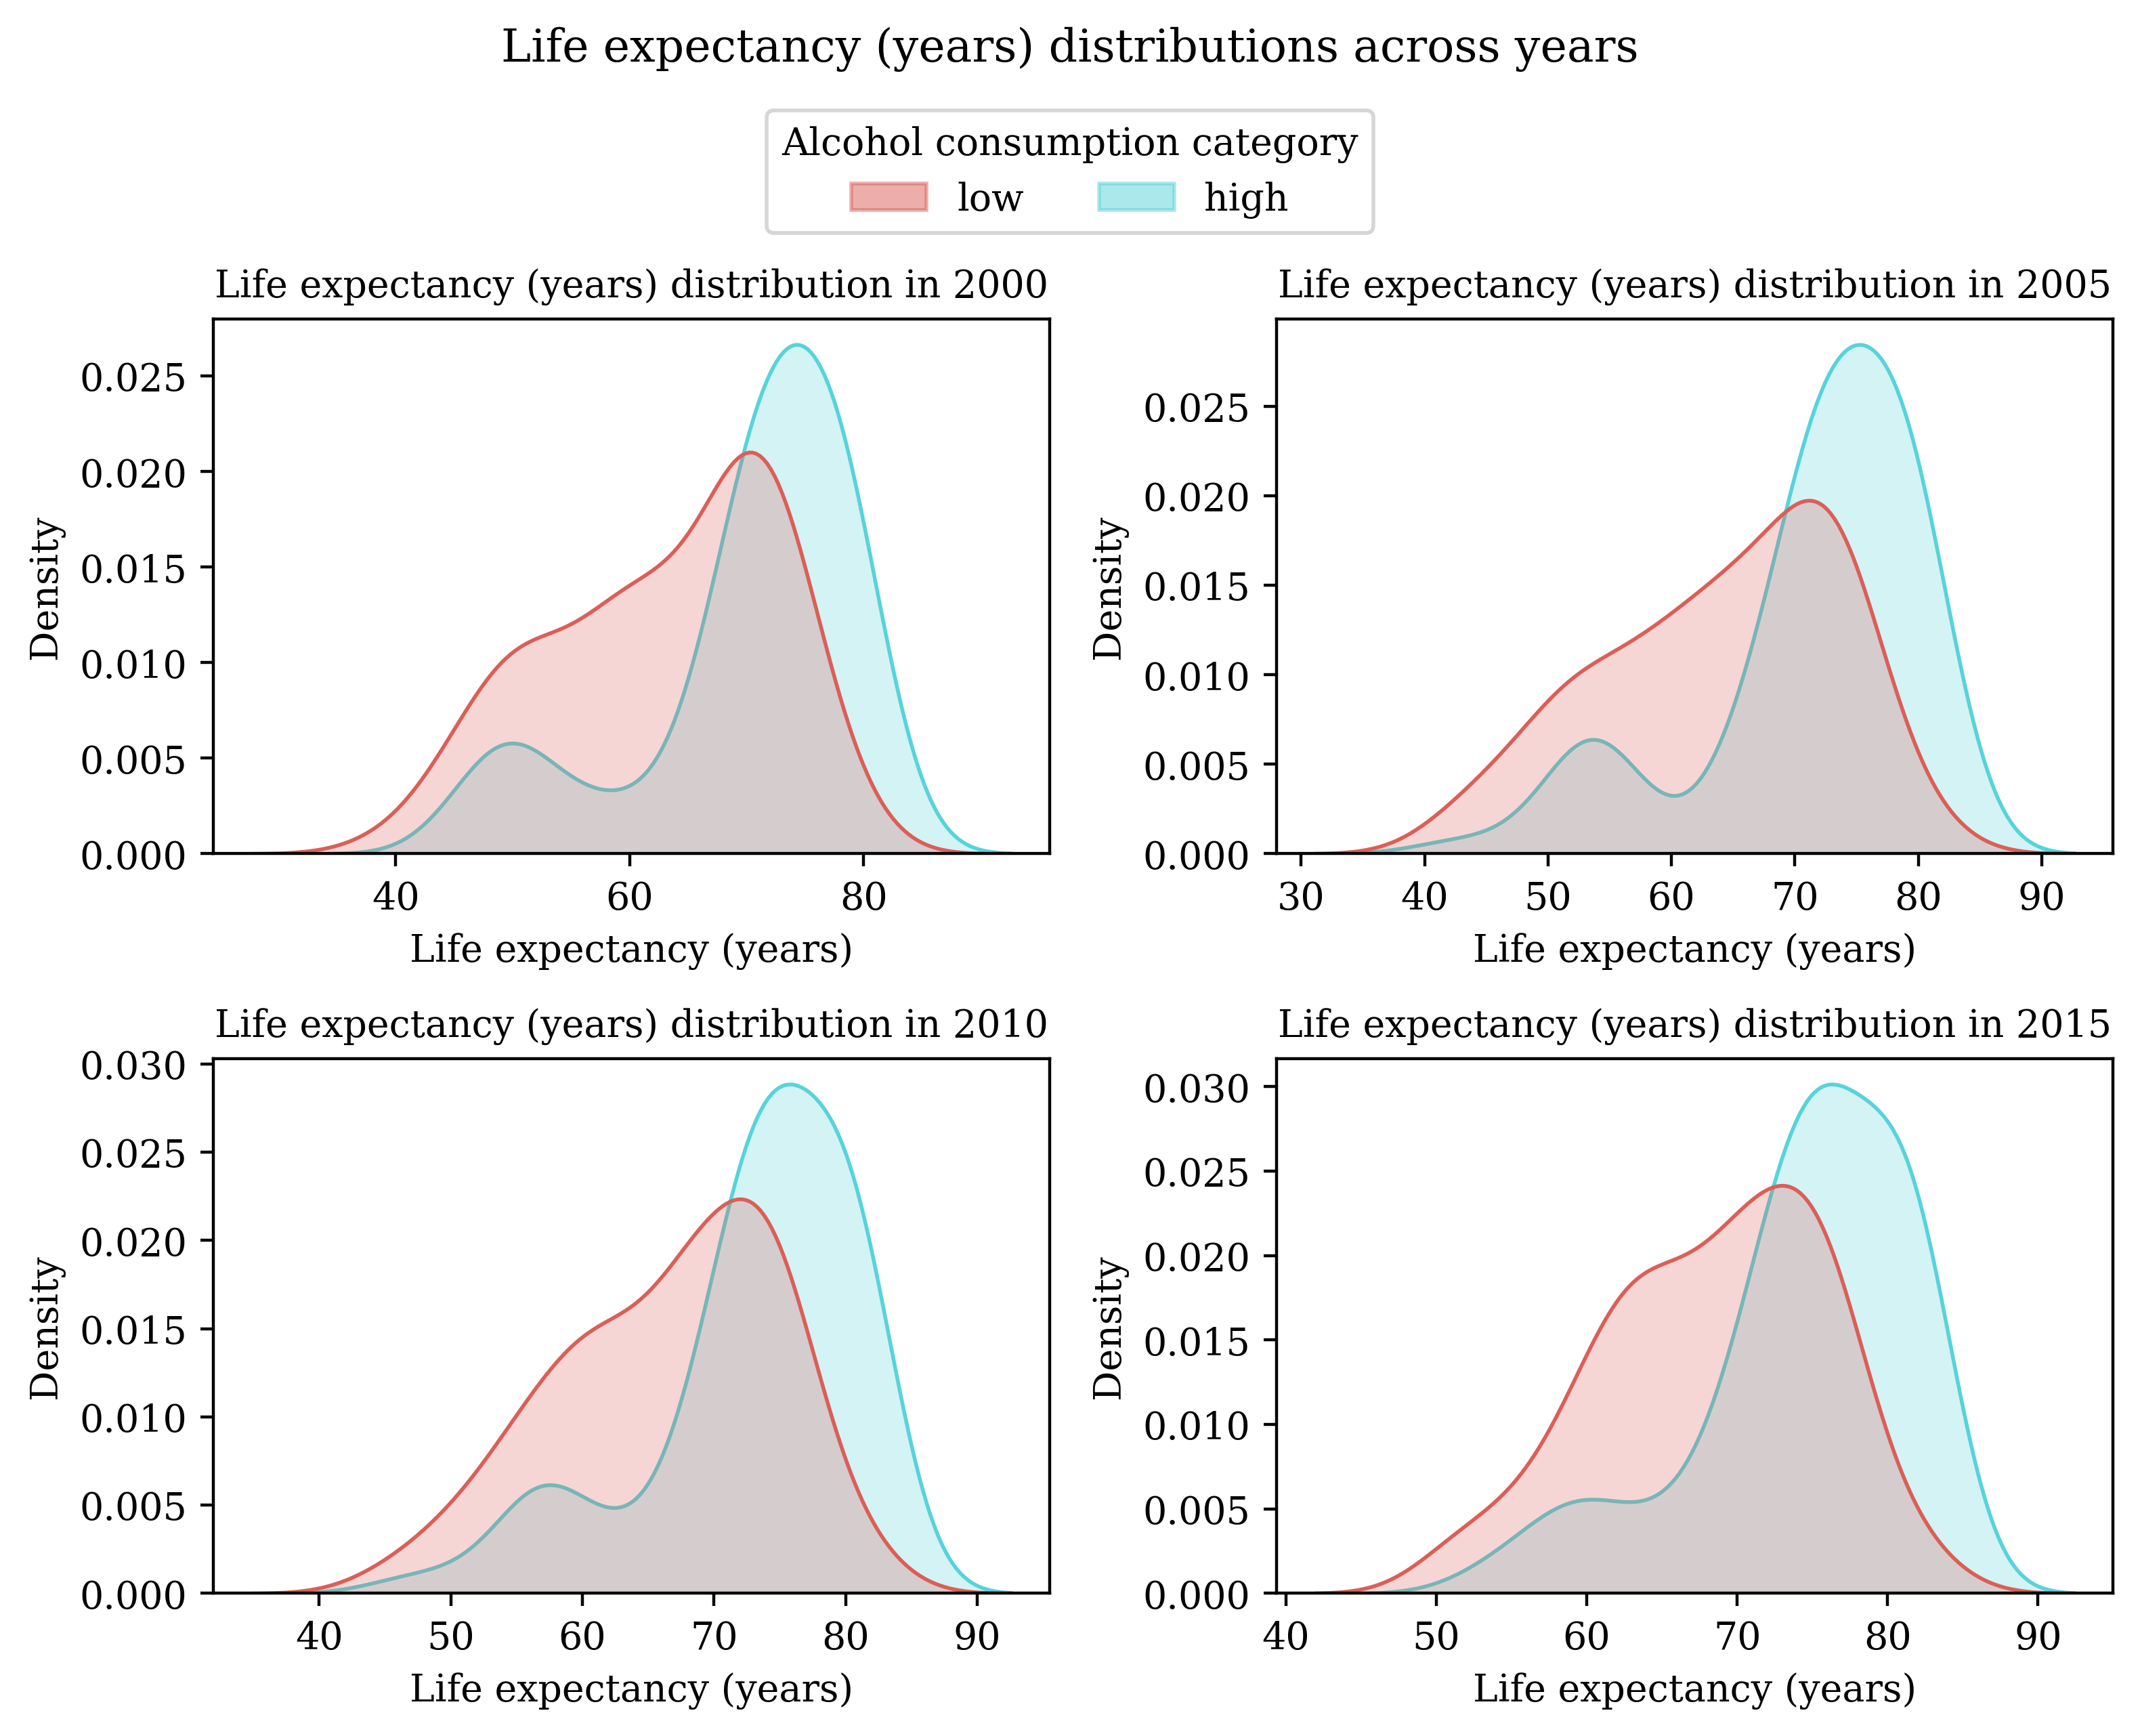

In [221]:
plot_feature_distribution(data, "Life expectancy (years)", hue="Alcohol consumption category")

In [222]:
indices_list = ["Alcohol consumption category", "Country"]

#### Normality
$H_{0}$: The data is normally distributed.  
$H_{1}$: The data is not normally distributed.   

In [223]:
alcohol_categories = ["low", "high"]
alcohol_categories_normality_dfs = []
for category in alcohol_categories:
    alcohol_categories_normality_dfs.append(
        create_normality_test_df(
        data=data,
        indices_list=indices_list, selected_index_value = category,
        selected_column=SELECTED_COLUMN, selected_column_values_list=YEARS,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

alcohol_categories_normality_df = pd.concat(alcohol_categories_normality_dfs, keys=alcohol_categories, names=["Category"], axis=0)

In [224]:
alcohol_categories_normality_df

Year  D value  p value Reject $H_0$
Category                                       
low      0  2000    0.131    0.076           No
         1  2005    0.104    0.277           No
         2  2010    0.085    0.518           No
         3  2015    0.088    0.471           No
high     0  2000    0.193    0.003          Yes
         1  2005    0.176    0.006          Yes
         2  2010    0.150    0.031           No
         3  2015    0.111    0.205           No

#### Variance Homogeneity

$H_{0}$: The variances of the samples are same.  
$H_{1}$: The variances of the samples are different.

In [225]:
variance_homogeneity_df = create_variance_homogeneity_test_df(data,
                              indices_list = indices_list,
                              selected_index_values=alcohol_categories,
                              selected_column=SELECTED_COLUMN, selected_column_values=YEARS,
                              selected_feature_to_test=SELECTED_FEATURE_TO_TEST)
variance_homogeneity_df

Year  W value  p value Reject $H_0$
0  2000    3.127    0.079           No
1  2005    3.275    0.072           No
2  2010    1.892    0.171           No
3  2015    1.363    0.245           No

Since in some years the distribution is normal with equal variance, while in others it isn't, we'll use the T-test and U-test accordingly.

In [226]:
t_years = [2010 , 2015]
u_years = [2000 , 2005]

#### Independent 2-sample T-test

$H_{0}$: $\mu_{\text{low alcohol consumption}}\le \mu_{\text{high alcohol consumption}}$     

We use the T-test, since we do not know the standard deviation of the samples.

In addition, we use a one-sided test since we have a priori assumptions regarding the relation between alcohol consumption and life expectancy.

In [227]:
alcohol_categories_pairs = [("low", "high")]
alcohol_categories_t_dfs = []

for year in t_years:
    alcohol_categories_t_dfs.append(
        create_independent_2_sample_t_test_df(
        data=data,
        indices_list=indices_list, selected_index_values_pairs_list = alcohol_categories_pairs,
        selected_column=SELECTED_COLUMN, selected_column_value=year,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

alcohol_categories_t_df = pd.concat(alcohol_categories_t_dfs, keys=t_years, names=["Year"], axis=0)

In [228]:
alcohol_categories_t_df

$H_0$  T value  p value (one-sided) Reject $H_0$
Year                                                                          
2010 0  $\mu_{low} \leq \mu_{high}$   -5.312                  1.0           No
2015 0  $\mu_{low} \leq \mu_{high}$   -5.678                  1.0           No

#### Independent Mann-Whitney U rank Test

$H_{0}: \text{median}_{\text{low alcohol consumption}} \le \text{median}_{\text{high alcohol consumption}}  $
  
We will use a one-sided test since we have a priori assumptions regarding the relation between alcohol consumption and life expectancy.

In [229]:
alcohol_categories_pairs = [("low", "high")]
alcohol_categories_u_dfs = []

for year in u_years:
    alcohol_categories_u_dfs.append(
        create_independent_Mann_Whitney_U_rank_test_df(
        data=data,
        indices_list=indices_list, selected_index_values_pairs_list = alcohol_categories_pairs,
        selected_column=SELECTED_COLUMN, selected_column_value=year,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

alcohol_categories_u_df = pd.concat(alcohol_categories_u_dfs, keys=u_years, names=["Year"], axis=0)

In [230]:
alcohol_categories_u_df

$H_0$  U value  \
Year                                                         
2000 0  $\text{med}_{low} \leq \text{med}_{high}$   2159.5   
2005 0  $\text{med}_{low} \leq \text{med}_{high}$   2091.0   

        p value (one-sided) Reject $H_0$  
Year                                      
2000 0                  1.0           No  
2005 0                  1.0           No

### Schooling

In [231]:
data.insert(13, "Schooling category", pd.cut(data['Schooling (years)'], bins=3, labels=['low', 'medium', 'high']))

In [232]:
data

Country      Continent  Year  Population (millions)  log Population  \
0       Turkiye           Asia  2015                  78.53        1.895036   
1         Spain         Europe  2015                  46.44        1.666892   
2         India           Asia  2007                1183.21        3.073062   
3        Guyana  South America  2006                   0.75       -0.124939   
4        Israel           Asia  2012                   7.91        0.898176   
...         ...            ...   ...                    ...             ...   
2859      Niger         Africa  2000                  11.33        1.054230   
2860   Mongolia           Asia  2009                   2.67        0.426511   
2861  Sri Lanka           Asia  2004                  19.39        1.287578   
2862  Lithuania         Europe  2002                   3.44        0.536558   
2863    Iceland         Europe  2011                   0.32       -0.494850   

      GDP per capita ($)  log GDP per capita GDP category  BMI (kg/m^2)  \
0                  11006            4.041630       medium          27.8   
1                  25742            4.410642         high          26.0   
2                   1076            3.031812          low          21.2   
3                   4146            3.617629       medium          25.3   
4                  33995            4.531415         high          27.0   
...                  ...                 ...          ...           ...   
2859                 399            2.600973          low          20.8   
2860                2515            3.400538       medium          25.3   
2861                2130            3.328380       medium          21.9   
2862                7424            3.870638       medium          26.1   
2863               48934            4.689611         high          26.1   

     BMI category  Alcohol consumption (L) Alcohol consumption category  \
0            high                    1.320                          low   
1            high                   10.350                         high   
2             low                    1.570                          low   
3            high                    5.680                         high   
4            high                    2.890                          low   
...           ...                      ...                          ...   
2859          low                    0.092                          low   
2860         high                    6.560                         high   
2861          low                    1.560                          low   
2862         high                   11.000                         high   
2863         high                    6.840                         high   

      Schooling (years) Schooling category  Life expectancy (years)  
0                   7.8             medium                     76.5  
1                   9.7             medium                     82.8  
2                   5.0                low                     65.4  
3                   7.9             medium                     67.0  
4                  12.8               high                     81.7  
...                 ...                ...                      ...  
2859                1.1                low                     49.9  
2860                9.1             medium                     66.9  
2861               10.3               high                     74.3  
2862               11.1               high                     71.8  
2863               11.0               high                     82.4  

[2864 rows x 15 columns]

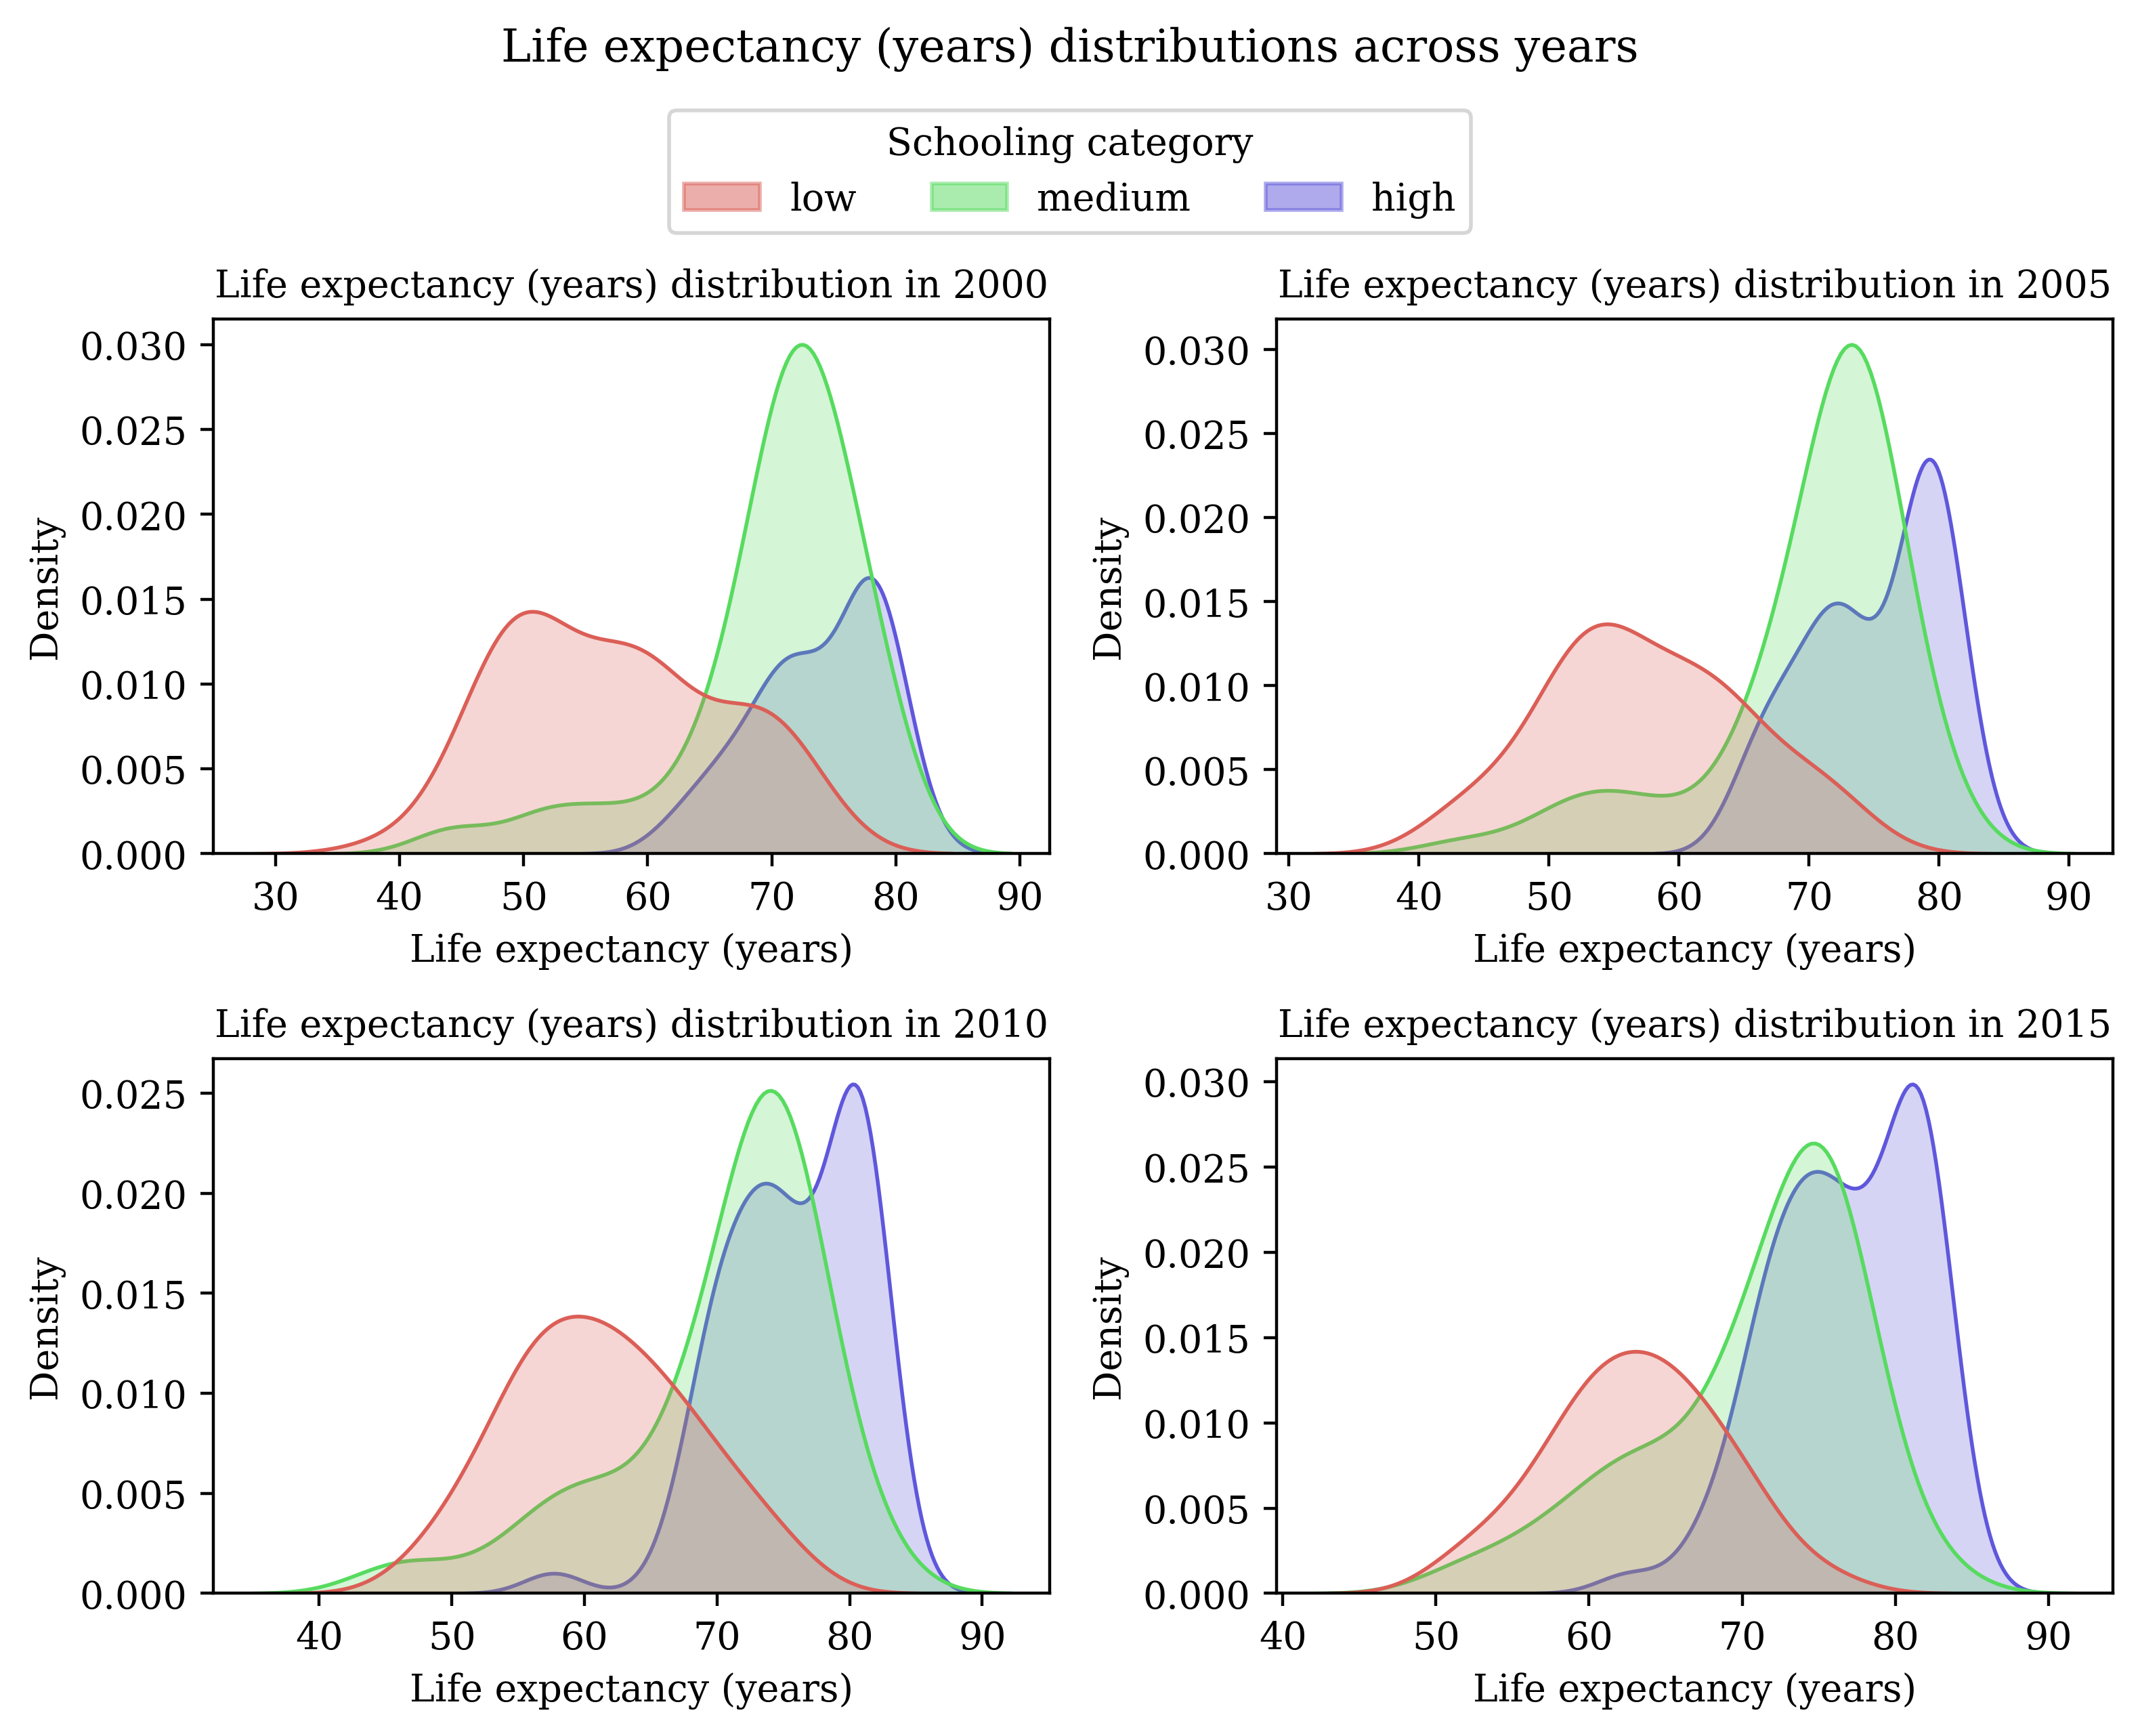

In [233]:
plot_feature_distribution(data, "Life expectancy (years)", hue="Schooling category")

In [234]:
indices_list = ["Schooling category", "Country"]

#### Normality
$H_{0}$: The data is normally distributed.  
$H_{1}$: The data is not normally distributed.   

In [235]:
schooling_categories = ["low", "medium", "high"]
schooling_categories_normality_dfs = []
for category in schooling_categories:
    schooling_categories_normality_dfs.append(
        create_normality_test_df(
        data=data,
        indices_list=indices_list, selected_index_value = category,
        selected_column=SELECTED_COLUMN, selected_column_values_list=YEARS,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

schooling_categories_normality_df = pd.concat(schooling_categories_normality_dfs, keys=schooling_categories, names=["Category"], axis=0)

In [236]:
schooling_categories_normality_df

Year  D value  p value Reject $H_0$
Category                                       
low      0  2000    0.127    0.230           No
         1  2005    0.085    0.813           No
         2  2010    0.079    0.895           No
         3  2015    0.055    0.999           No
medium   0  2000    0.189    0.008          Yes
         1  2005    0.191    0.008          Yes
         2  2010    0.190    0.012          Yes
         3  2015    0.150    0.080           No
high     0  2000    0.164    0.218           No
         1  2005    0.186    0.047           No
         2  2010    0.130    0.228           No
         3  2015    0.133    0.153           No

#### Variance Homogeneity

$H_{0}$: The variances of the samples are same.  
$H_{1}$: The variances of the samples are different.

In [237]:
variance_homogeneity_df = create_variance_homogeneity_test_df(data,
                              indices_list = indices_list,
                              selected_index_values=schooling_categories,
                              selected_column=SELECTED_COLUMN, selected_column_values=YEARS,
                              selected_feature_to_test=SELECTED_FEATURE_TO_TEST)
variance_homogeneity_df

Year  W value  p value Reject $H_0$
0  2000    6.043    0.003          Yes
1  2005    2.302    0.103           No
2  2010    1.605    0.204           No
3  2015    1.981    0.141           No

Since in some years the distribution is normal with equal variance, while in others it isn't, we'll use the T-test and U-test accordingly.

In [238]:
t_years = [2015]
u_years = [2000 , 2005, 2010]

#### Independent 2-sample T-test

$H_{0}^1: \mu_{\text{medium schooling}} \le \mu_{\text{low schooling}}$

$H_{0}^2: \mu_{\text{high schooling}} \le \mu_{\text{medium schooling}}$

$H_{0}^3: \mu_{\text{high schooling}} \le \mu_{\text{low schooling}}$

  
We will use a one-sided test since we have a priori assumptions regarding the relation between schooling and life expectancy.

In [239]:
schooling_categories_pairs = [("medium", "low"), ("high", "medium"), ("high", "low")]
schooling_categories_t_dfs = []

for year in t_years:
    schooling_categories_t_dfs.append(
        create_independent_2_sample_t_test_df(
        data=data,
        indices_list=indices_list, selected_index_values_pairs_list = schooling_categories_pairs,
        selected_column=SELECTED_COLUMN, selected_column_value=year,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

schooling_categories_t_df = pd.concat(schooling_categories_t_dfs, keys=t_years, names=["Year"], axis=0)

In [240]:
schooling_categories_t_df

$H_0$  T value  p value (one-sided)  \
Year                                                                   
2015 0   $\mu_{medium} \leq \mu_{low}$    6.074                  0.0   
     1  $\mu_{high} \leq \mu_{medium}$    5.940                  0.0   
     2     $\mu_{high} \leq \mu_{low}$   13.774                  0.0   

       Reject $H_0$  
Year                 
2015 0          Yes  
     1          Yes  
     2          Yes

#### Independent Mann-Whitney U rank Test

$H_{0}^1: \text{median}_{\text{medium schooling}} \le \text{median}_{\text{low schooling}}$

$H_{0}^2: \text{median}_{\text{high schooling}} \le \text{median}_{\text{medium schooling}}$

$H_{0}^3: \text{median}_{\text{high schooling}} \le \text{median}_{\text{low schooling}}$

  
We will use a one-sided test since we have a priori assumptions regarding the relation between schooling and life expectancy.

In [241]:
schooling_categories_pairs = [("medium", "low"), ("high", "medium"), ("high", "low")]
schooling_categories_u_dfs = []

for year in u_years:
    schooling_categories_u_dfs.append(
        create_independent_Mann_Whitney_U_rank_test_df(
        data=data,
        indices_list=indices_list, selected_index_values_pairs_list = schooling_categories_pairs,
        selected_column=SELECTED_COLUMN, selected_column_value=year,
        selected_feature_to_test=SELECTED_FEATURE_TO_TEST
        )
    )

schooling_categories_u_df = pd.concat(schooling_categories_u_dfs, keys=u_years, names=["Year"], axis=0)

In [242]:
schooling_categories_u_df

$H_0$  U value  \
Year                                                            
2000 0   $\text{med}_{medium} \leq \text{med}_{low}$   4225.5   
     1  $\text{med}_{high} \leq \text{med}_{medium}$   1928.0   
     2     $\text{med}_{high} \leq \text{med}_{low}$   2349.0   
2005 0   $\text{med}_{medium} \leq \text{med}_{low}$   3450.5   
     1  $\text{med}_{high} \leq \text{med}_{medium}$   2666.0   
     2     $\text{med}_{high} \leq \text{med}_{low}$   2671.0   
2010 0   $\text{med}_{medium} \leq \text{med}_{low}$   2733.5   
     1  $\text{med}_{high} \leq \text{med}_{medium}$   3005.0   
     2     $\text{med}_{high} \leq \text{med}_{low}$   2893.0   

        p value (one-sided) Reject $H_0$  
Year                                      
2000 0                0.000          Yes  
     1                0.004          Yes  
     2                0.000          Yes  
2005 0                0.000          Yes  
     1                0.000          Yes  
     2                0.000          Yes  
2010 0                0.000          Yes  
     1                0.000          Yes  
     2                0.000          Yes

## Correlation Matrix

In [338]:
from scipy.stats import pearsonr

def calculate_p_values(data):
    cols = data.select_dtypes(include='number').columns
    p_values = pd.DataFrame(columns=cols, index=cols)
    for row in cols:
        for col in cols:
            p_values.loc[row, col] = pearsonr(data[row], data[col])[1]

    return p_values

def plot_correlation_matrix(data, significance=True):
    # Create correlation matrix
    corr = data.corr(numeric_only=True)

    # Create mask
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    np.fill_diagonal(mask, False)

    fix, ax = plt.subplots(figsize=(10, 7))
    plt.title("Correlation matrix with p-values", fontsize=12)

    # Generate heatmap
    heatmap = sns.heatmap(corr,
                          square=True,
                          vmax=1.0,
                          vmin=-1.0,
                          annot= True,
                          annot_kws=dict(fontsize=14),
                          fmt='.2f',
                          linewidths=0.5,
                          cmap='RdBu',
                          mask=mask,
                          ax=ax)


    if significance:
        # Calculate p-values
        p_values = calculate_p_values(data)

        # Mask the p-values
        mask_pvalues = np.triu(np.ones_like(p_values), k=1)

        # Assign p-value annotations, include asterisks for significance
        for i in range (p_values.shape[0]):
          for j in range(p_values.shape[1]):
            if mask_pvalues[i, j]:
              p_value = p_values.iloc[i, j]
              if not np.isnan(p_value):
                correlation_value = corr.iloc[i, j]
                text_color = 'white' if correlation_value >= (0.45) or correlation_value <= (-0.45) else 'black'
                ax.text(i + 0.5, j + 0.8, f'(p = {p_value:.2f})',
                            horizontalalignment='center',
                            verticalalignment='center',
                            fontsize=10,
                            color=text_color)
    plt.show()

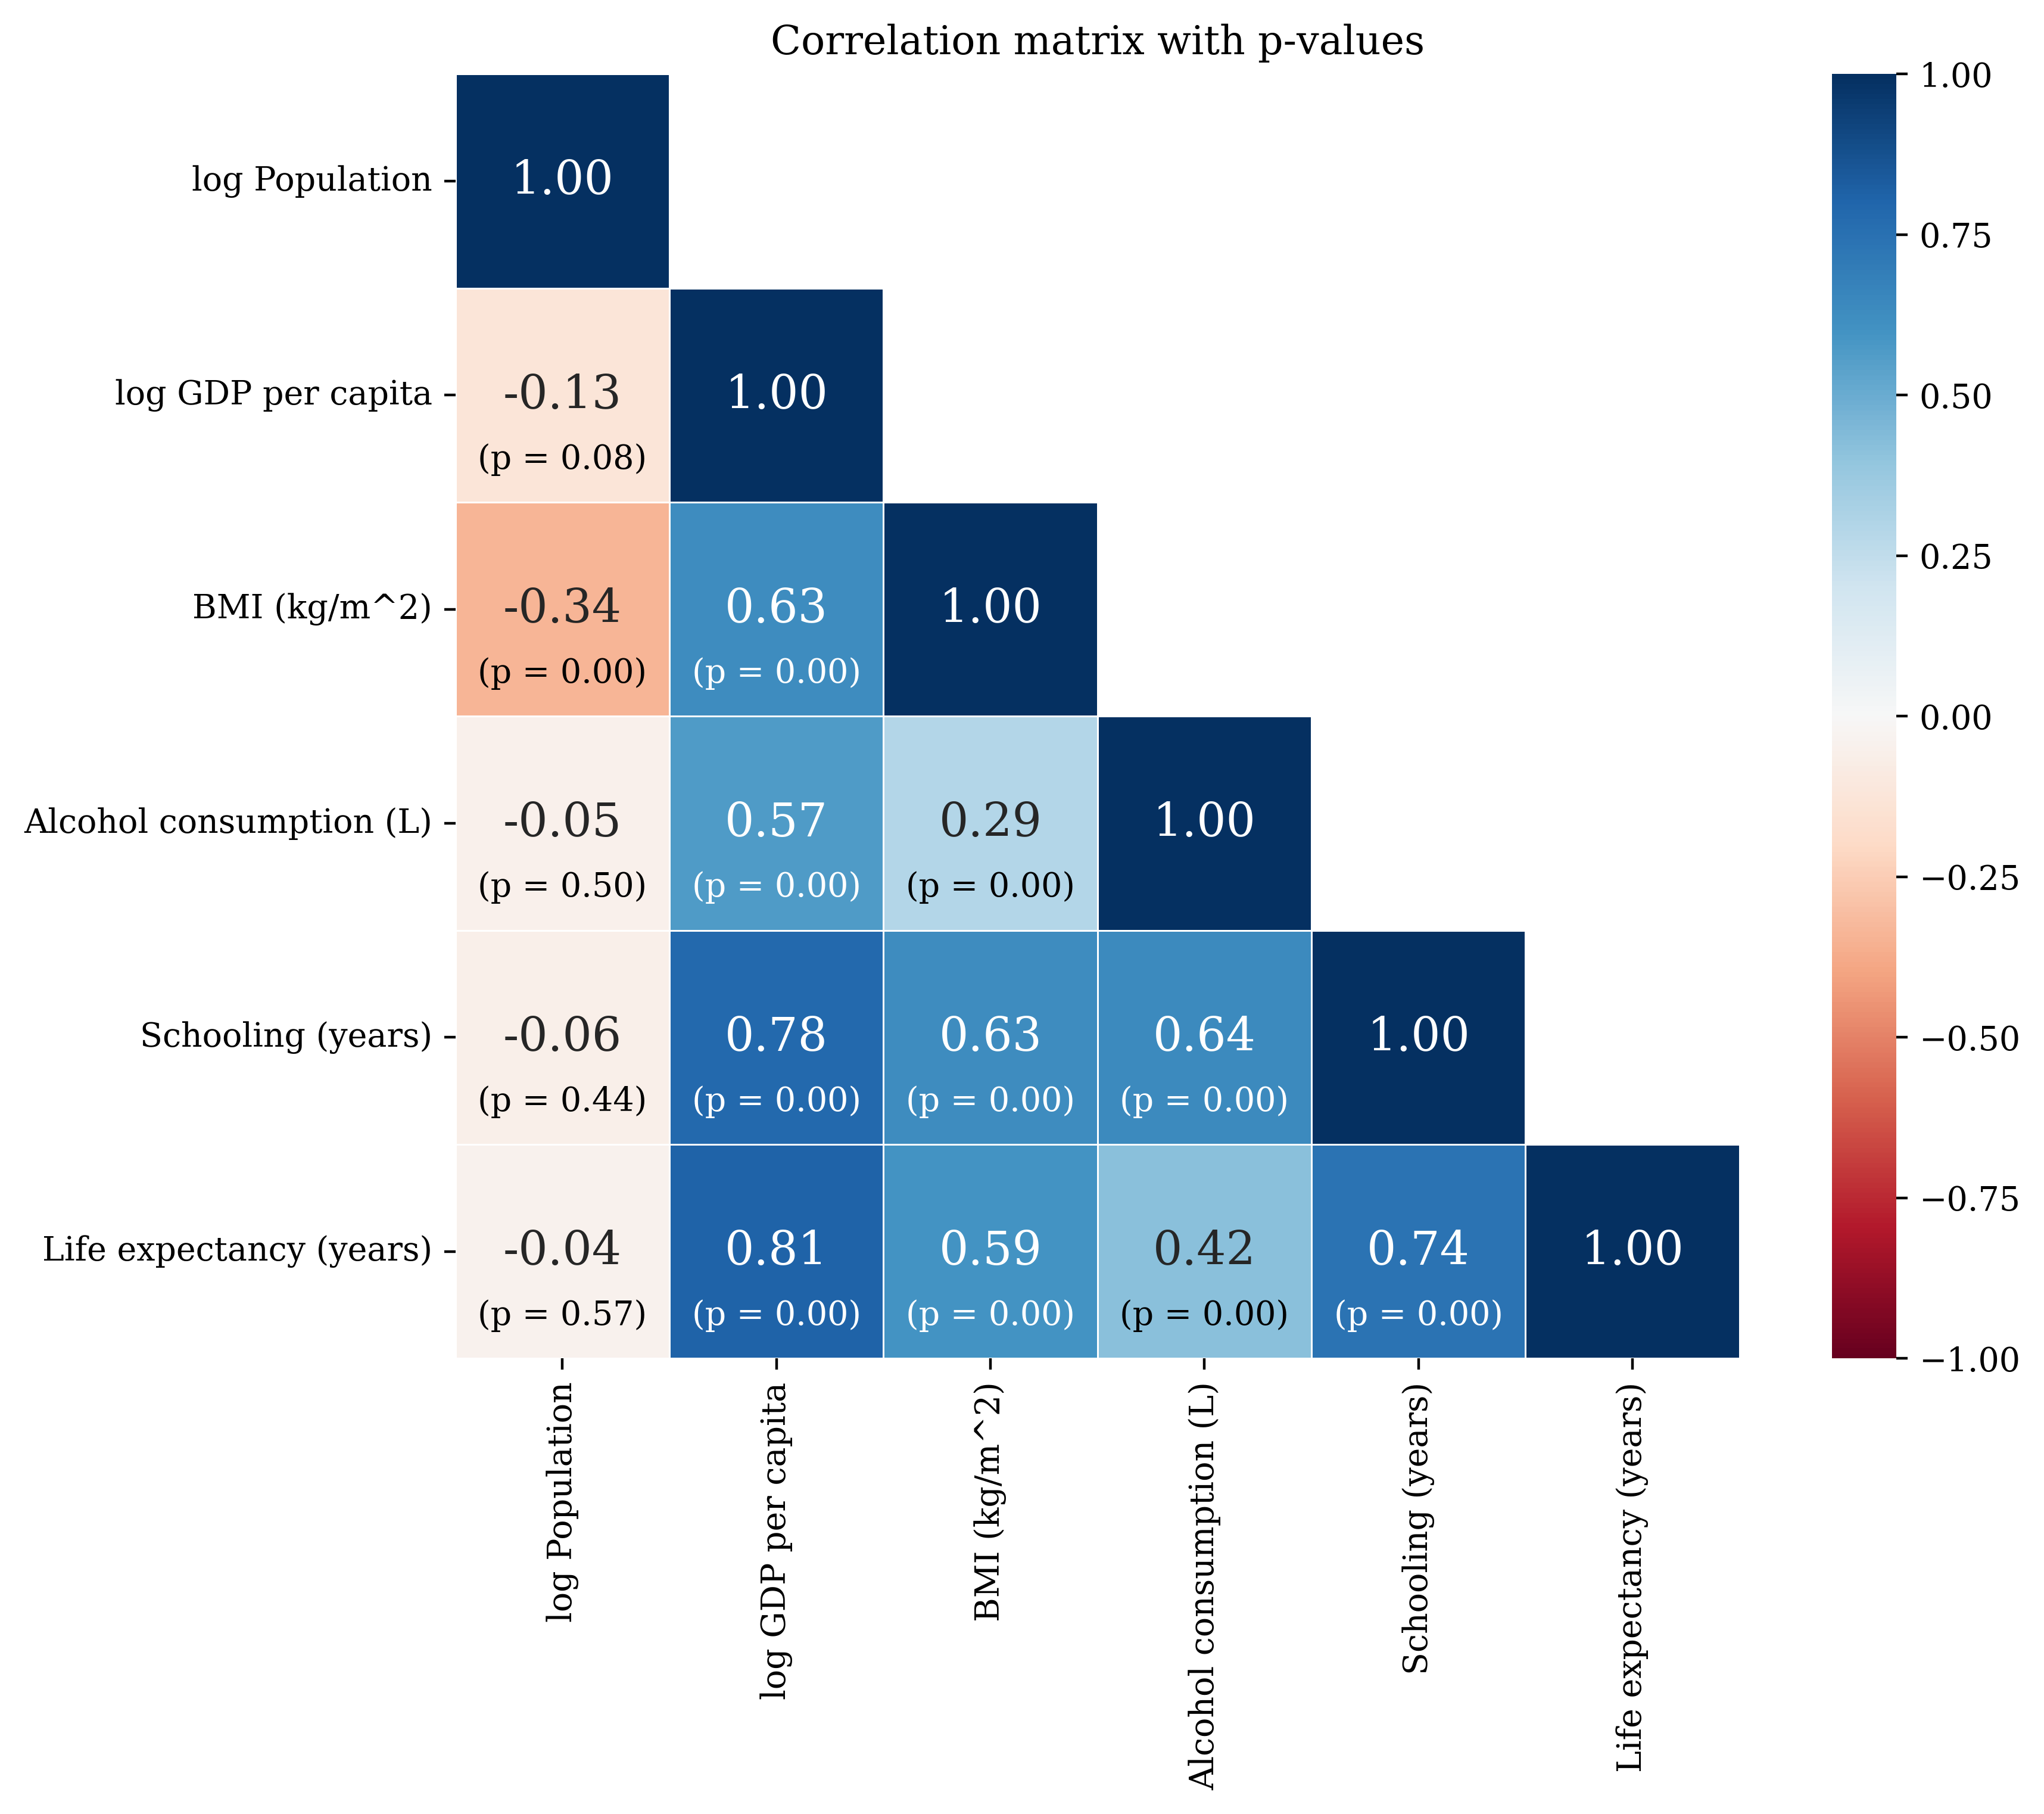

In [339]:
plot_correlation_matrix(average_by_country)

## Regression

In [352]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def linear_regression_fit(data, numerical_columns, categorical_columns, target):
    # Separate the feature columns and target
    X = data[numerical_columns + categorical_columns].copy()
    Y = data[target].copy()

    # Preprocessing: scale numerical data and one-hot encode categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('cat', OneHotEncoder(drop='first'), categorical_columns)  # Drop first to avoid multicollinearity
        ]
    )

    # Apply preprocessing to X
    X_processed = preprocessor.fit_transform(X)
    
    # Add a constant (intercept) term
    X_processed = sm.add_constant(X_processed)
    
    # Normalize Y
    Y_scaled = StandardScaler().fit_transform(Y.to_frame())

    # Fit the OLS model
    model = sm.OLS(Y_scaled, X_processed)
    results = model.fit()

    return model, results

In [353]:
numerical_columns = ['Year', 'log Population', 'log GDP per capita', 'BMI (kg/m^2)', 'Alcohol consumption (L)', 'Schooling (years)']
categorical_columns = ['Continent']
target = "Life expectancy (years)"
model, results = linear_regression_fit(data, numerical_columns, categorical_columns, target)
print(results.summary())

[-1.19311752  1.42961738  0.45565382  0.8511764   0.02489629 -0.19934485
  0.          0.          1.          0.          0.        ]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     1055.
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:35:42   Log-Likelihood:                -1739.8
No. Observations:                2864   AIC:                             3504.
Df Residuals:                    2852   BIC:                             3575.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.9